# Multi-Omics Analysis & Modelling of Cervicovaginal Microenvironment

Notebook accompanies publication: "Multi-omics data integration reveals metabolome as the top predictor of the cervicovaginal microenvironment".

It includes:

[1) Import packages and set paths](#chap1)      

[2) Read & process datasets](#chap2)

[3) Exploratory analysis of omics datasets](#chap3)

[4) Training and evaluation of classifiers](#chap4)

[5) Training and evaluation of regressors](#chap5)

**To run this notebook, please setup the conda environment as described in `README.md` section "Setup for `a-modelling-HPV.ipynb`".**
         

<a id='chap1'></a>

## 1) Import packages and set paths

In [1]:
import warnings
import os
import pandas as pd
import skbio
from itertools import compress
from skbio.stats.ordination import pcoa

import qiime2
from qiime2.plugins import diversity

import matplotlib as mpl
from matplotlib.pylab import plt
from IPython.display import Image

# custom functions
from util_data_proc import (add_microbiome_data,
                            add_metabolome_data,
                            perform_taxonomic_classification, add_targets,
                            extract_microbiome_artifact)
from util_eda import (plot_data_avail_per_target,
                      return_pcoa_metrics_microbiome,
                      calc_pca_metrics_metabolome,
                      calc_pca_metrics_proteome,
                      merge_all_pca_metrics)
from util_classification import train_n_eval_classifier
from util_regression import train_n_eval_regressors

# R settings
import rpy2

plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-pastel')
mpl.rcParams['figure.dpi'] = 250

# jupyter magic commands
%load_ext rpy2.ipython
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

# location to retrieve raw-data
path2data = 'data-raw'

# location to save outputs
output_dir = 'a-modelling-output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# set random seed across all experiments
seed = 12


In [2]:
%%R -w 800 --type=cairo

# importing all required R packages required for omics visualisation
source("util_R_plotter.R")

R[write to console]: 
Attache Paket: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attache Paket: ‘cowplot’


R[write to console]: The following object is masked from ‘package:ggpubr’:

    get_legend


R[write to console]: 
Attache Paket: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: Th

<a id='chap2'></a>

## 2) Read & process datasets

### Get all features

In [3]:
# # read patient data (prefix 'F_pcov_') + immunoproteo data (prefix 'F_proteo_')
df_dataset = pd.read_csv(os.path.join(path2data, 'sample_metadata_n_proteome.tsv'), sep='\t',
                         index_col='sample-id')
print('Number of patient covariate features (tagged with F_pcov_): {}'.format(
    len([x for x in df_dataset.columns if x.startswith('F_pcov_')])))
print('Number of immunoproteome features (tagged with F_proteo_): {}'.format(
    len([x for x in df_dataset.columns if x.startswith('F_proteo_')])))

# read cancer biomarkers - needed for cancer biomarker regression
df_cancer_biomarkers = pd.read_csv(os.path.join(
    'data-raw', 'cancer_biomarkers.tsv'), sep='\t')
ls_cancer_biomarkers = df_cancer_biomarkers['cancer_biomarkers'].values.tolist(
)

# add microbiome data
df_dataset = add_microbiome_data(df_dataset, path2data)

# add metabolome data
df_dataset = add_metabolome_data(df_dataset, path2data)


Number of patient covariate features (tagged with F_pcov_): 8
Number of immunoproteome features (tagged with F_proteo_): 68

Getting microbiome data (tagged with F_micro_)...
Shape of added microbiome data: (98, 831)

Getting metabolome data (tagged with F_metabo_)
Shape of added metabolite data: (77, 475)


### Perform taxonomic classification (`taxa`)

In [4]:
# perform taxonomic classification
merged_taxonomy, taxonomy_qza = perform_taxonomic_classification(path2data)

# extract consensus taxonomy
taxonomy = merged_taxonomy[['Consensus Taxonomy']].copy(deep=True)
taxonomy.columns = ['Taxon']

# extract lowest available level of taxonomic classification - required for eval of classifiers
taxa = taxonomy['Taxon'].apply(lambda x: x.split(';')[-1] if len(x.split(';')[-1])>0 else x.split(';')[-2:][0] + ' unknown')

Reading existing taxonomic classification


### Get all Targets (`df_data_w_targets`)

In [5]:
# add targets ('T_')
df_data_w_targets = add_targets(df_dataset, path2data, taxonomy_qza)

# Targets to consider
ls_targets = [col for col in df_data_w_targets.columns if col.startswith(
    'T_') and col != 'T_infl_score_flt']
ls_targets


Adding targets

Add T_inflammation_score
Low     47
None    40
High    12
Name: T_inflammation, dtype: int64

Add T_disease_state
Ctrl_HPV_pos    31
HGD             27
Ctrl_HPV_neg    20
LGD             11
ICC             10
Name: T_disease_state, dtype: int64

Add T_lactobacillus_dominance
LD     51
NLD    48
Name: T_lactobacillus_dominance, dtype: int64

Add T_pH
Low     47
High    46
NaN      6
Name: T_pH, dtype: int64

Shape of df with targets: (99, 1388)


['T_disease_state', 'T_inflammation', 'T_lactobacillus_dominance', 'T_pH']

### Select samples with all omics data available

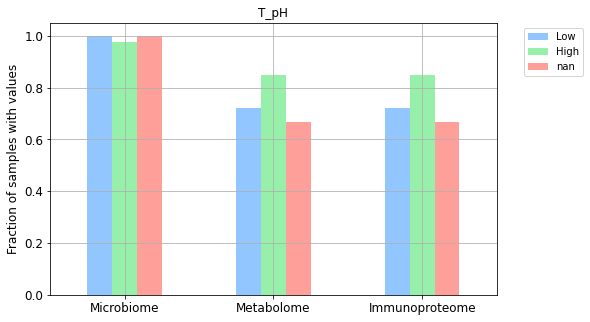

Absolute counts:
Low     47
High    46
NaN      6
Name: T_pH, dtype: int64


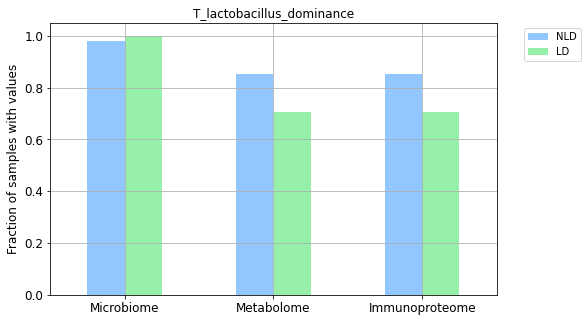

Absolute counts:
LD     51
NLD    48
Name: T_lactobacillus_dominance, dtype: int64


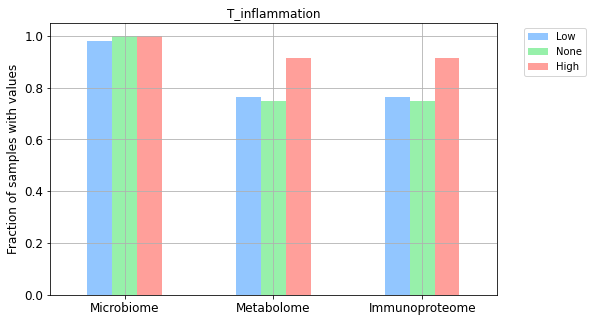

Absolute counts:
Low     47
None    40
High    12
Name: T_inflammation, dtype: int64


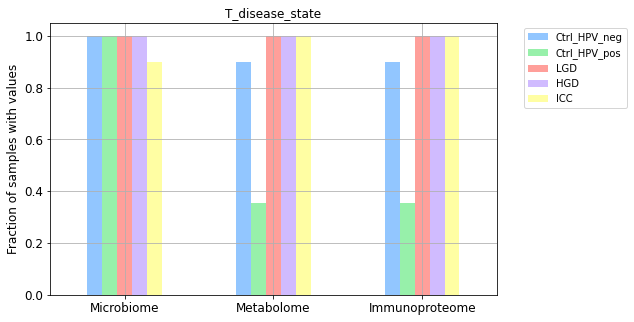

Absolute counts:
Ctrl_HPV_pos    31
HGD             27
Ctrl_HPV_neg    20
LGD             11
ICC             10
Name: T_disease_state, dtype: int64


In [6]:
# get omics availability in original dataset per target class

plot_data_avail_per_target(df_data_w_targets, ls_targets)

In [7]:
# remove all samples that don't have all omics and patient covariate features available
ls_microbiome_cols = [
    x for x in df_data_w_targets.columns if x.startswith('F_micro')]
ls_metabolome_cols = [
    x for x in df_data_w_targets.columns if x.startswith('F_metabo')]
ls_proteome_cols = [
    x for x in df_data_w_targets.columns if x.startswith('F_proteo')]
ls_pcov = [x for x in df_data_w_targets.columns if x.startswith('F_pcov_')]

nb_samples_before = df_data_w_targets.shape[0]
print('Total number of samples before: {}'.format(nb_samples_before))
ls_all_omics = ls_microbiome_cols + \
    ls_metabolome_cols + ls_proteome_cols + ls_pcov

df_data_w_targets_sel = df_data_w_targets[
    ~df_data_w_targets.loc[:, ls_all_omics+ls_targets]
    .isnull().any(axis=1)]
print('Total number of samples with all info: {}'.format(
    df_data_w_targets_sel.shape[0]))

print('Class count in all info available:')
for target in ls_targets:
    print(df_data_w_targets_sel[target].value_counts(dropna=False))

# remove other dataframe - ensuring only selected is used below
del df_data_w_targets


Total number of samples before: 99
Total number of samples with all info: 72
Class count in all info available:
HGD             27
Ctrl_HPV_neg    18
LGD             10
Ctrl_HPV_pos     9
ICC              8
Name: T_disease_state, dtype: int64
Low     34
None    28
High    10
Name: T_inflammation, dtype: int64
NLD    40
LD     32
Name: T_lactobacillus_dominance, dtype: int64
High    38
Low     34
Name: T_pH, dtype: int64


### Remove features with same value in all samples  (`df_data_w_targets_sel`)

In [8]:
# remove micro features that don't occur in any of the
# 72 samples (value == 0.0 everywhere) - 68 features

print('Before: {}'.format(df_data_w_targets_sel.shape))

ls_microbiome_features = [
    x for x in df_data_w_targets_sel.columns if x.startswith('F_micro_')]
bool_missing_micro = (
    df_data_w_targets_sel[ls_microbiome_features] == 0.0).all().values
ls_missing_micro = list(compress(ls_microbiome_features, bool_missing_micro))
ls_features2select = [
    x for x in df_data_w_targets_sel.columns if x not in ls_missing_micro]

df_data_w_targets_sel = df_data_w_targets_sel[ls_features2select].copy(
    deep=True)
print('After: {}'.format(df_data_w_targets_sel.shape))


Before: (72, 1388)
After: (72, 1320)


In [9]:
# remove metabolites that all have the same value (stddev = 0.0) (8 features affected)
print('Before: {}'.format(df_data_w_targets_sel.shape))
ls_metabolite_features = [
    x for x in df_data_w_targets_sel.columns if x.startswith('F_metabo_')]

std_metabo = df_data_w_targets_sel[ls_metabolite_features].describe(
).loc['std']
ls_zero_stddev = std_metabo[std_metabo == 0.0].index.to_list()
feat2select = [
    x for x in df_data_w_targets_sel.columns if x not in ls_zero_stddev]

df_data_w_targets_sel = df_data_w_targets_sel[feat2select].copy(deep=True)
print('After: {}'.format(df_data_w_targets_sel.shape))


Before: (72, 1320)
After: (72, 1312)


In [10]:
# proteome does not have any features where all values are same
ls_proteome = [
    x for x in df_data_w_targets_sel.columns if x.startswith('F_proteo_')]
std_proteo = df_data_w_targets_sel[ls_proteome].describe().loc['std']
ls_zero_stddev = std_proteo[std_proteo == 0.0].index.to_list()
print(len(ls_zero_stddev))


0


In [11]:
# extract updated feature names
ls_microbiome_cols = [x for x in df_data_w_targets_sel.columns if x.startswith('F_micro')]
ls_metabolome_cols = [x for x in df_data_w_targets_sel.columns if x.startswith('F_metabo')]
ls_proteome_cols = [x for x in df_data_w_targets_sel.columns if x.startswith('F_proteo')]

<a id='chap3'></a>

## 3) Exploratory analysis

In [12]:
# create subfolder for exploratory data analysis results
output_dir_eda = os.path.join(output_dir, 'eda')
if not os.path.exists(output_dir_eda):
    os.makedirs(output_dir_eda)

### Microbiome: alpha diversity analysis

In [13]:
microbiome_table = extract_microbiome_artifact(df_data_w_targets_sel)

# calculating alpha diversity
art_alpha_diversity,  = diversity.actions.alpha(
    table=microbiome_table, metric='shannon')
df_alpha_div = art_alpha_diversity.view(pd.Series).to_frame()
df_alpha_div.index.name = 'SampleID'

# compare alpha group significance
alpha_div_viz, = diversity.actions.alpha_group_significance(
    alpha_diversity=art_alpha_diversity,
    metadata=qiime2.Metadata(df_data_w_targets_sel[ls_targets]))

print('Alpha Div Boxplots per cat class and Kruskal-Wallis '
      'test results are saved as qiime viz file in:')
alpha_div_viz.save(os.path.join(output_dir_eda, 'alpha-div-viz.qzv'))


Alpha Div Boxplots per cat class and Kruskal-Wallis test results are saved as qiime viz file in:


'a-modelling-output/eda/alpha-div-viz.qzv'

### Microbiome: beta diversity analysis

In [14]:
# calculate beta diversity (bray-curtis, jaccard) & perform PCoA from distance matrix
dict_beta_results = {}

for beta_metric in ['braycurtis', 'jaccard']:
    art_beta_div_dis_matrix, = diversity.actions.beta(
        table=microbiome_table, metric=beta_metric)

    beta_pcoa_results = pcoa(art_beta_div_dis_matrix.view(
        skbio.DistanceMatrix), number_of_dimensions=2)

    dict_beta_results[beta_metric+'_dis_matrix'] = art_beta_div_dis_matrix
    dict_beta_results[beta_metric+'_pcoa_res'] = beta_pcoa_results

# analyse stat. trends of beta diversity with PERMANOVA
# = tests the hypothesis that samples within a group are more
# similar to each other than they are to samples in another group
for metric in ['braycurtis', 'jaccard']:
    for target in ls_targets:
        beta_div_viz, = diversity.actions.beta_group_significance(
            distance_matrix=dict_beta_results[metric+'_dis_matrix'],
            metadata=qiime2.Metadata(
                df_data_w_targets_sel[ls_targets]).get_column(target),
            pairwise=False)

        print('Beta Div {} PERMANOVA results for {}:'.format(metric, target))
        path2save = os.path.join(
            output_dir_eda, 'beta-div-permanova-{}-{}.qzv'.format(metric, target))
        print(path2save)
        beta_div_viz.save(path2save)
        print()


Beta Div braycurtis PERMANOVA results for T_disease_state:
a-modelling-output/eda/beta-div-permanova-braycurtis-T_disease_state.qzv

Beta Div braycurtis PERMANOVA results for T_inflammation:
a-modelling-output/eda/beta-div-permanova-braycurtis-T_inflammation.qzv

Beta Div braycurtis PERMANOVA results for T_lactobacillus_dominance:
a-modelling-output/eda/beta-div-permanova-braycurtis-T_lactobacillus_dominance.qzv

Beta Div braycurtis PERMANOVA results for T_pH:
a-modelling-output/eda/beta-div-permanova-braycurtis-T_pH.qzv

Beta Div jaccard PERMANOVA results for T_disease_state:
a-modelling-output/eda/beta-div-permanova-jaccard-T_disease_state.qzv

Beta Div jaccard PERMANOVA results for T_inflammation:
a-modelling-output/eda/beta-div-permanova-jaccard-T_inflammation.qzv

Beta Div jaccard PERMANOVA results for T_lactobacillus_dominance:
a-modelling-output/eda/beta-div-permanova-jaccard-T_lactobacillus_dominance.qzv

Beta Div jaccard PERMANOVA results for T_pH:
a-modelling-output/eda/beta-

<Figure size 432x288 with 0 Axes>

### Omics: PCoA beta-div of micro- and PCA of meta-/proteome

In [15]:
# microbiome pcoa metrics
dict_explained_var = {}
df_pcoa_micro, dict_explained_var = return_pcoa_metrics_microbiome(dict_beta_results,
                                                                   dict_explained_var,
                                                                   df_data_w_targets_sel,
                                                                   ls_targets)
# metabolome pca metrics
df_pca_metab, dict_explained_var = calc_pca_metrics_metabolome(dict_explained_var,
                                                               df_data_w_targets_sel,
                                                               ls_targets)

# proteome pca metrics
df_pca_proteo, dict_explained_var = calc_pca_metrics_proteome(dict_explained_var,
                                                              df_data_w_targets_sel,
                                                              ls_targets)
                                                              


In [16]:
# merge derived metrics to one df for explained variance
# and pca coordinates with targets
beta_div2_choose = 'jaccard'
df_explained_var = pd.DataFrame(dict_explained_var)
df_pca_all = merge_all_pca_metrics(df_pcoa_micro, beta_div2_choose,
                                   df_pca_metab, df_pca_proteo)


visualise in ggplot2

In [17]:
%%R -w 800 --type=cairo --input beta_div2_choose,df_pca_all,df_explained_var,ls_targets,output_dir_eda --res 100 -u px 9000

plot_pca_scatters(beta_div2_choose,df_pca_all,df_explained_var,ls_targets,output_dir_eda)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(target)` instead of `target` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


Notes on PC(o)A plots:           
`stat_ellipse` calculates confidence interval ellipse assuming a multivariate normal distribution (`type='norm'`) drawn at a 95 % confidence level (`level=0.95`).


Plotting image saved in R function `plot_pca_scatters`:


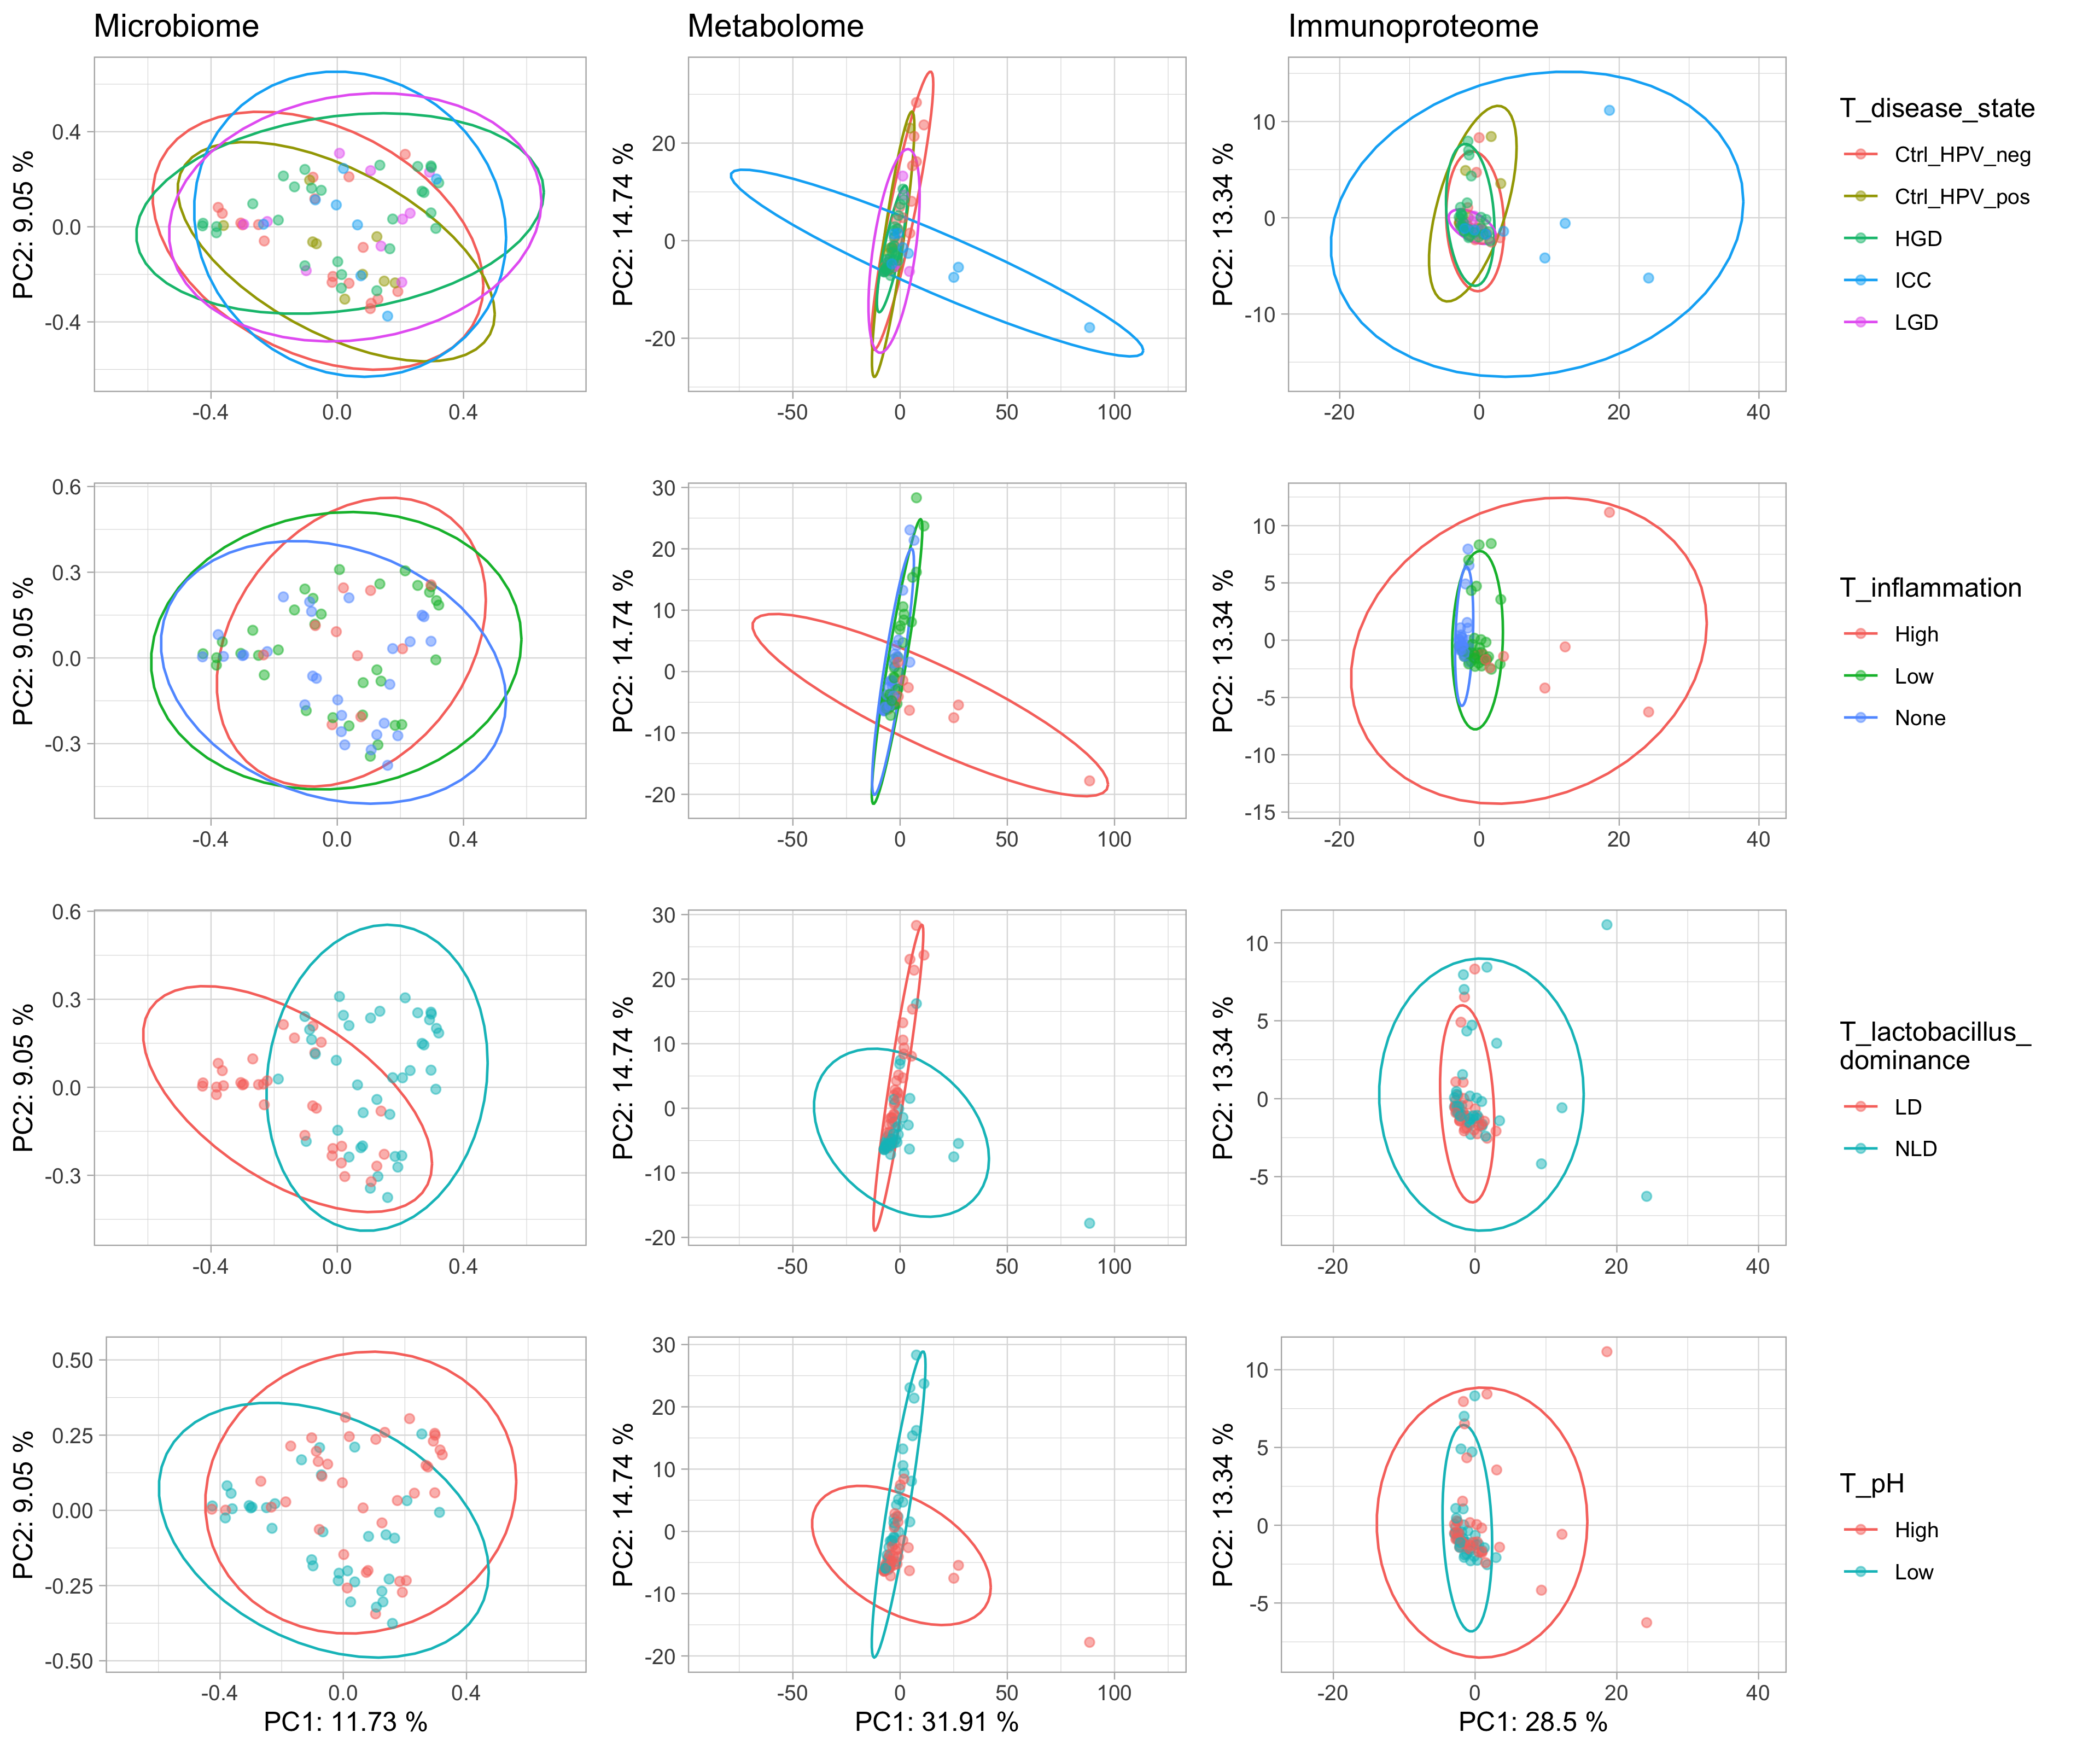

In [18]:
print("Plotting image saved in R function `plot_pca_scatters`:")
Image(filename=os.path.join(output_dir_eda, "omics-pca-ggplot.png"))


<a id='chap4'></a>

## 4) Train and evaluate classifiers

### Predict `disease_status`


Training classifier for T_disease_state...
Shape of feature table: (72, 1306)
['Estimator Accuracy: 0.4875 ± 0.09782389946287384']

Evaluating combined classifier...
Confusion matrix and ROC curve saved as Q2artifact here: a-modelling-output/classifiers/T_disease_state-accuracy.qzv


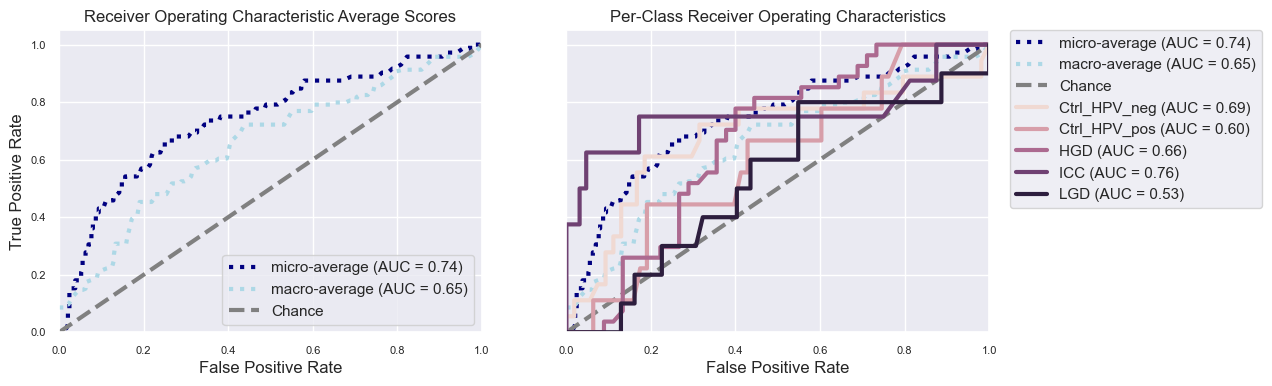

<Figure size 600x400 with 0 Axes>

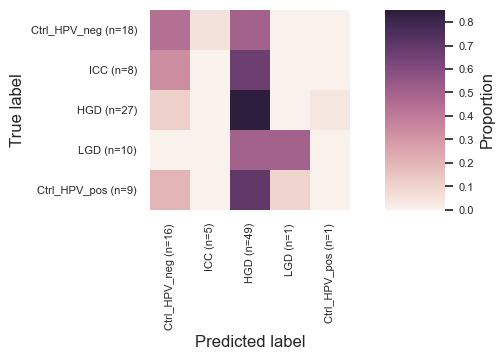

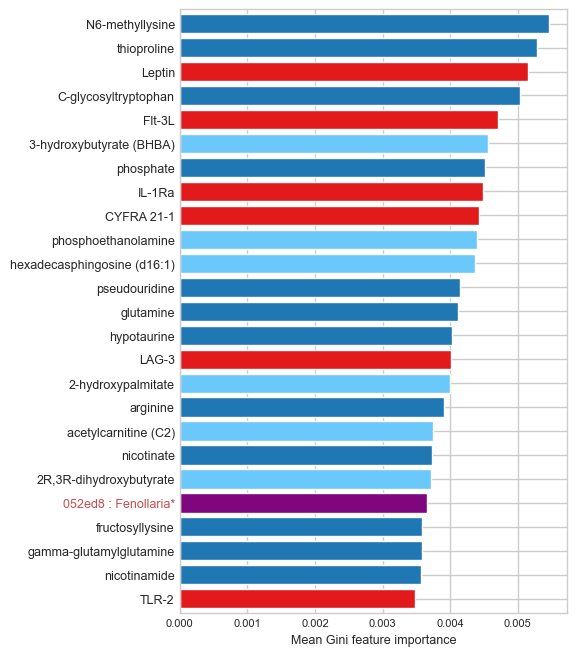


Evaluating separate-omics classifiers...
Microbiome - Number of features: 763
['Estimator Accuracy: 0.33214285714285713 ± 0.08718968296952644']
Metabolome - Number of features: 467
['Estimator Accuracy: 0.4321428571428571 ± 0.10375599318809965']
Immunoproteome - Number of features: 68
['Estimator Accuracy: 0.5017857142857143 ± 0.16139735791783313']


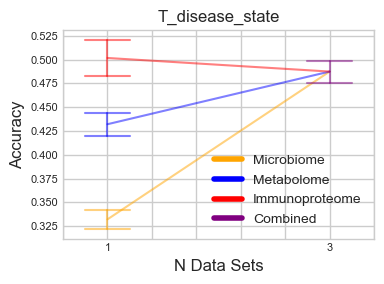

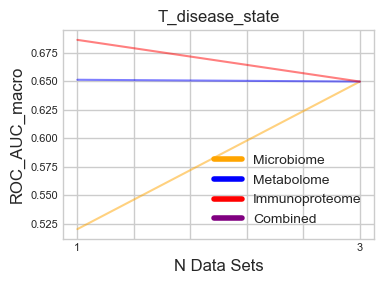

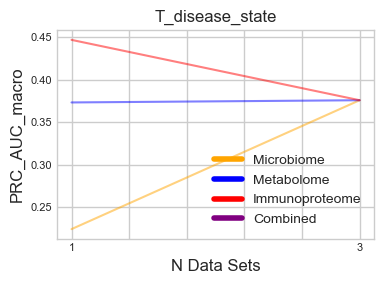


Evaluating feature abundances for combined classifier...


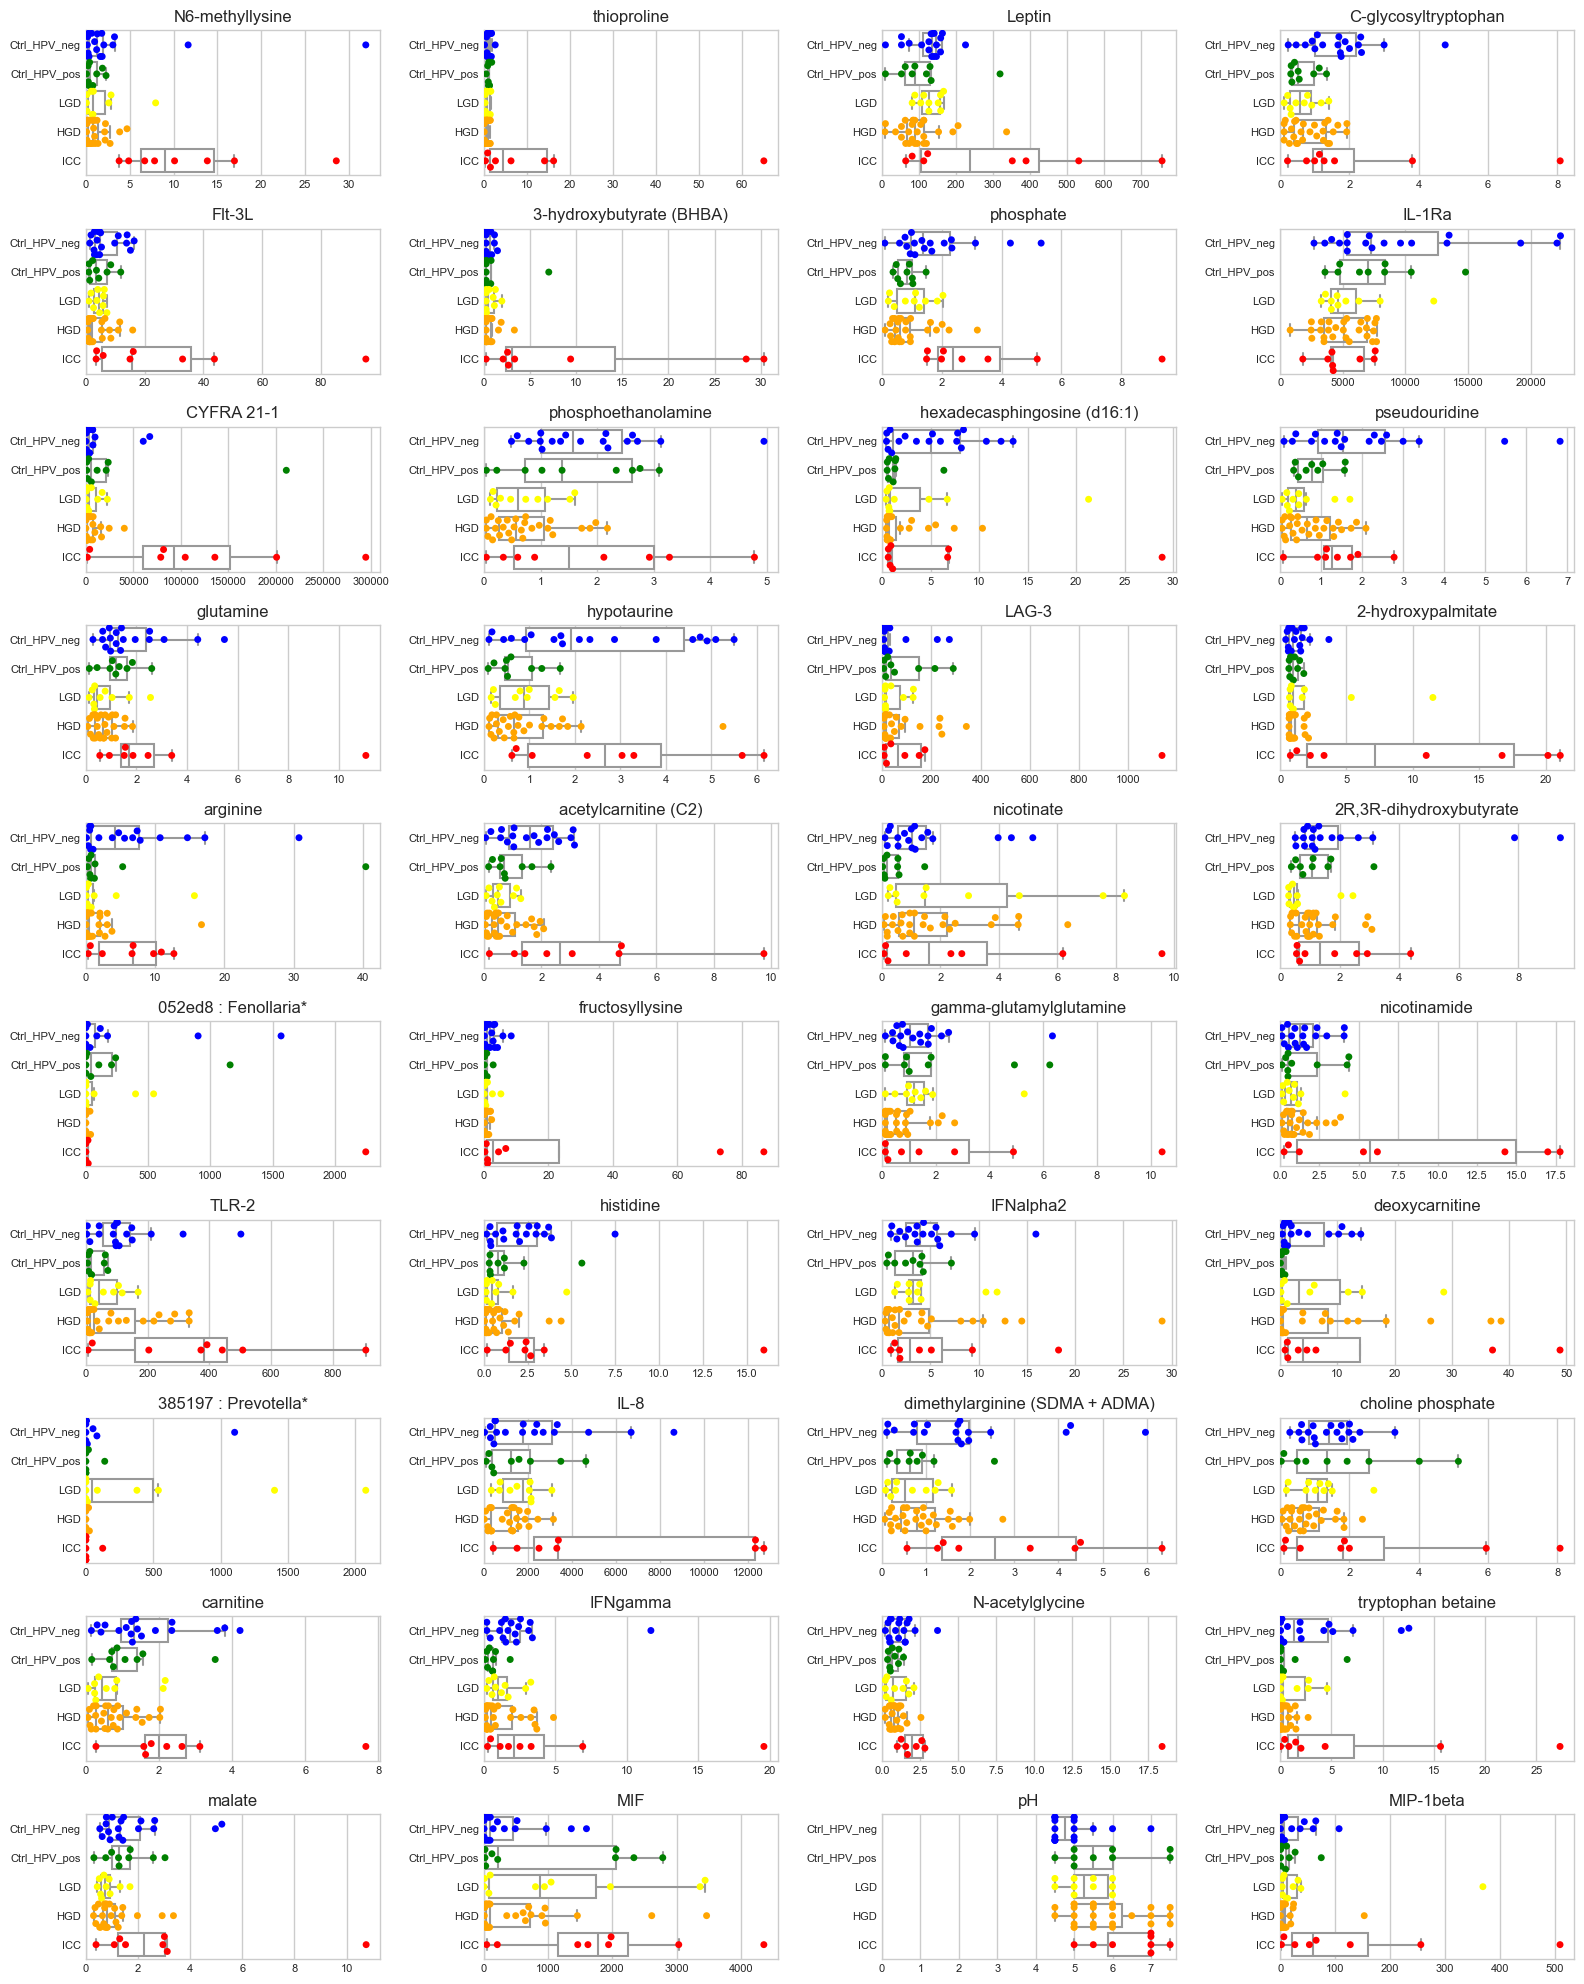

In [19]:
ls_features_disease = [
    x for x in df_data_w_targets_sel.columns if x.startswith('F_')]

ls_class_order = ['Ctrl_HPV_neg', 'Ctrl_HPV_pos', 'LGD', 'HGD', 'ICC']
dic_color_palette = {'Ctrl_HPV_neg': 'blue',
                     'Ctrl_HPV_pos': 'green',
                     'LGD': 'yellow',
                     'HGD': 'orange',
                     'ICC': 'red'}

train_n_eval_classifier('T_disease_state',
                        ls_features_disease,
                        df_data_w_targets_sel,
                        taxa,
                        ls_class_order,
                        dic_color_palette,
                        seed,
                        output_dir)


### Predict `genital_inflammation`


Training classifier for T_inflammation...
Shape of feature table: (72, 1291)
['Estimator Accuracy: 0.7803571428571429 ± 0.13074794648561056']

Evaluating combined classifier...
Confusion matrix and ROC curve saved as Q2artifact here: a-modelling-output/classifiers/T_inflammation-accuracy.qzv


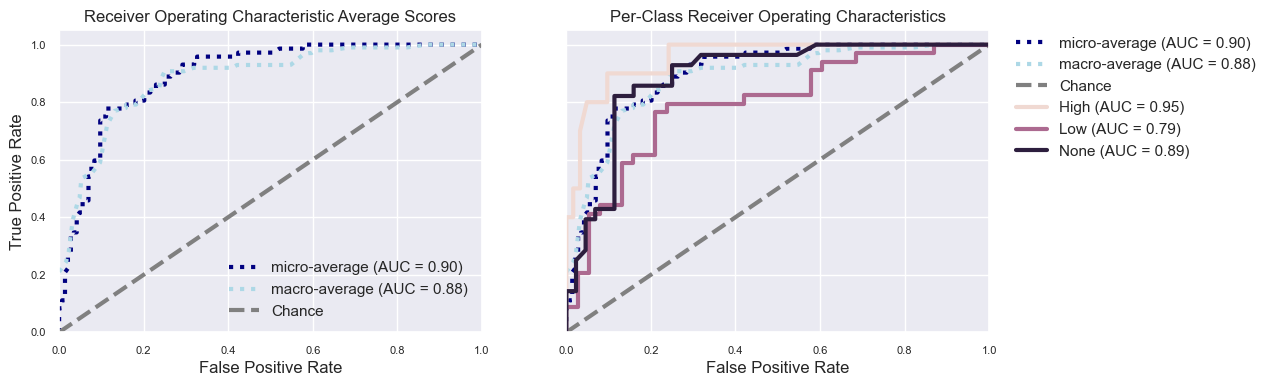

<Figure size 600x400 with 0 Axes>

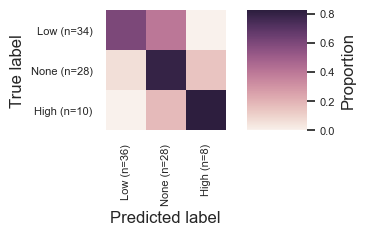

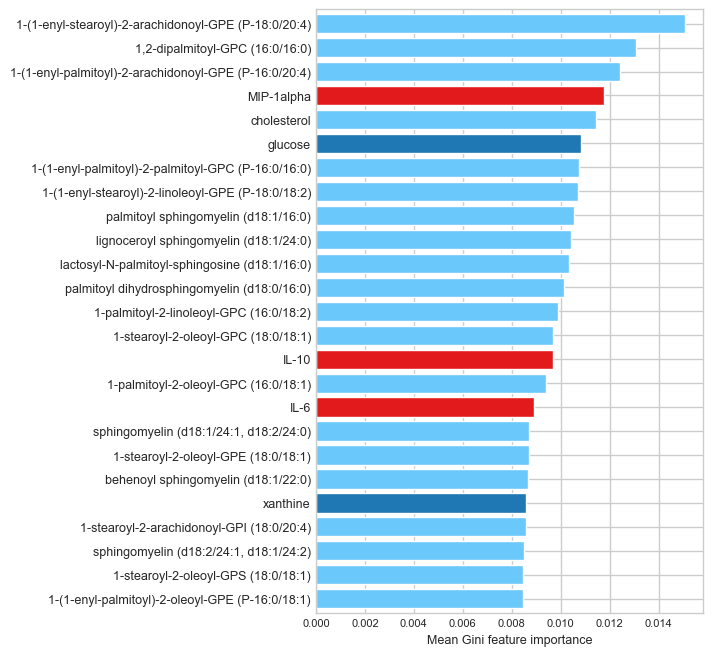


Evaluating separate-omics classifiers...
Microbiome - Number of features: 763
['Estimator Accuracy: 0.5125 ± 0.09782389946287386']
Metabolome - Number of features: 467
['Estimator Accuracy: 0.7535714285714286 ± 0.13965153425726537']
Immunoproteome - Number of features: 61
['Estimator Accuracy: 0.7642857142857143 ± 0.12314956892547618']


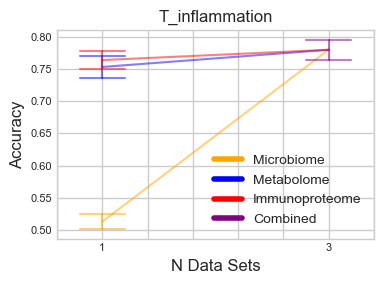

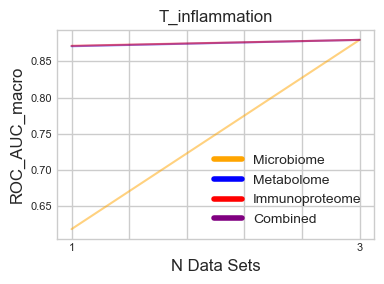

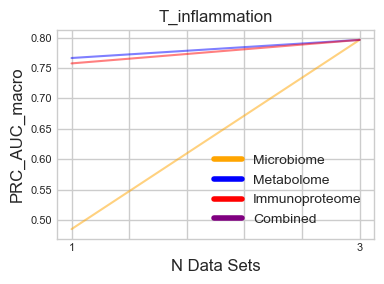


Evaluating feature abundances for combined classifier...


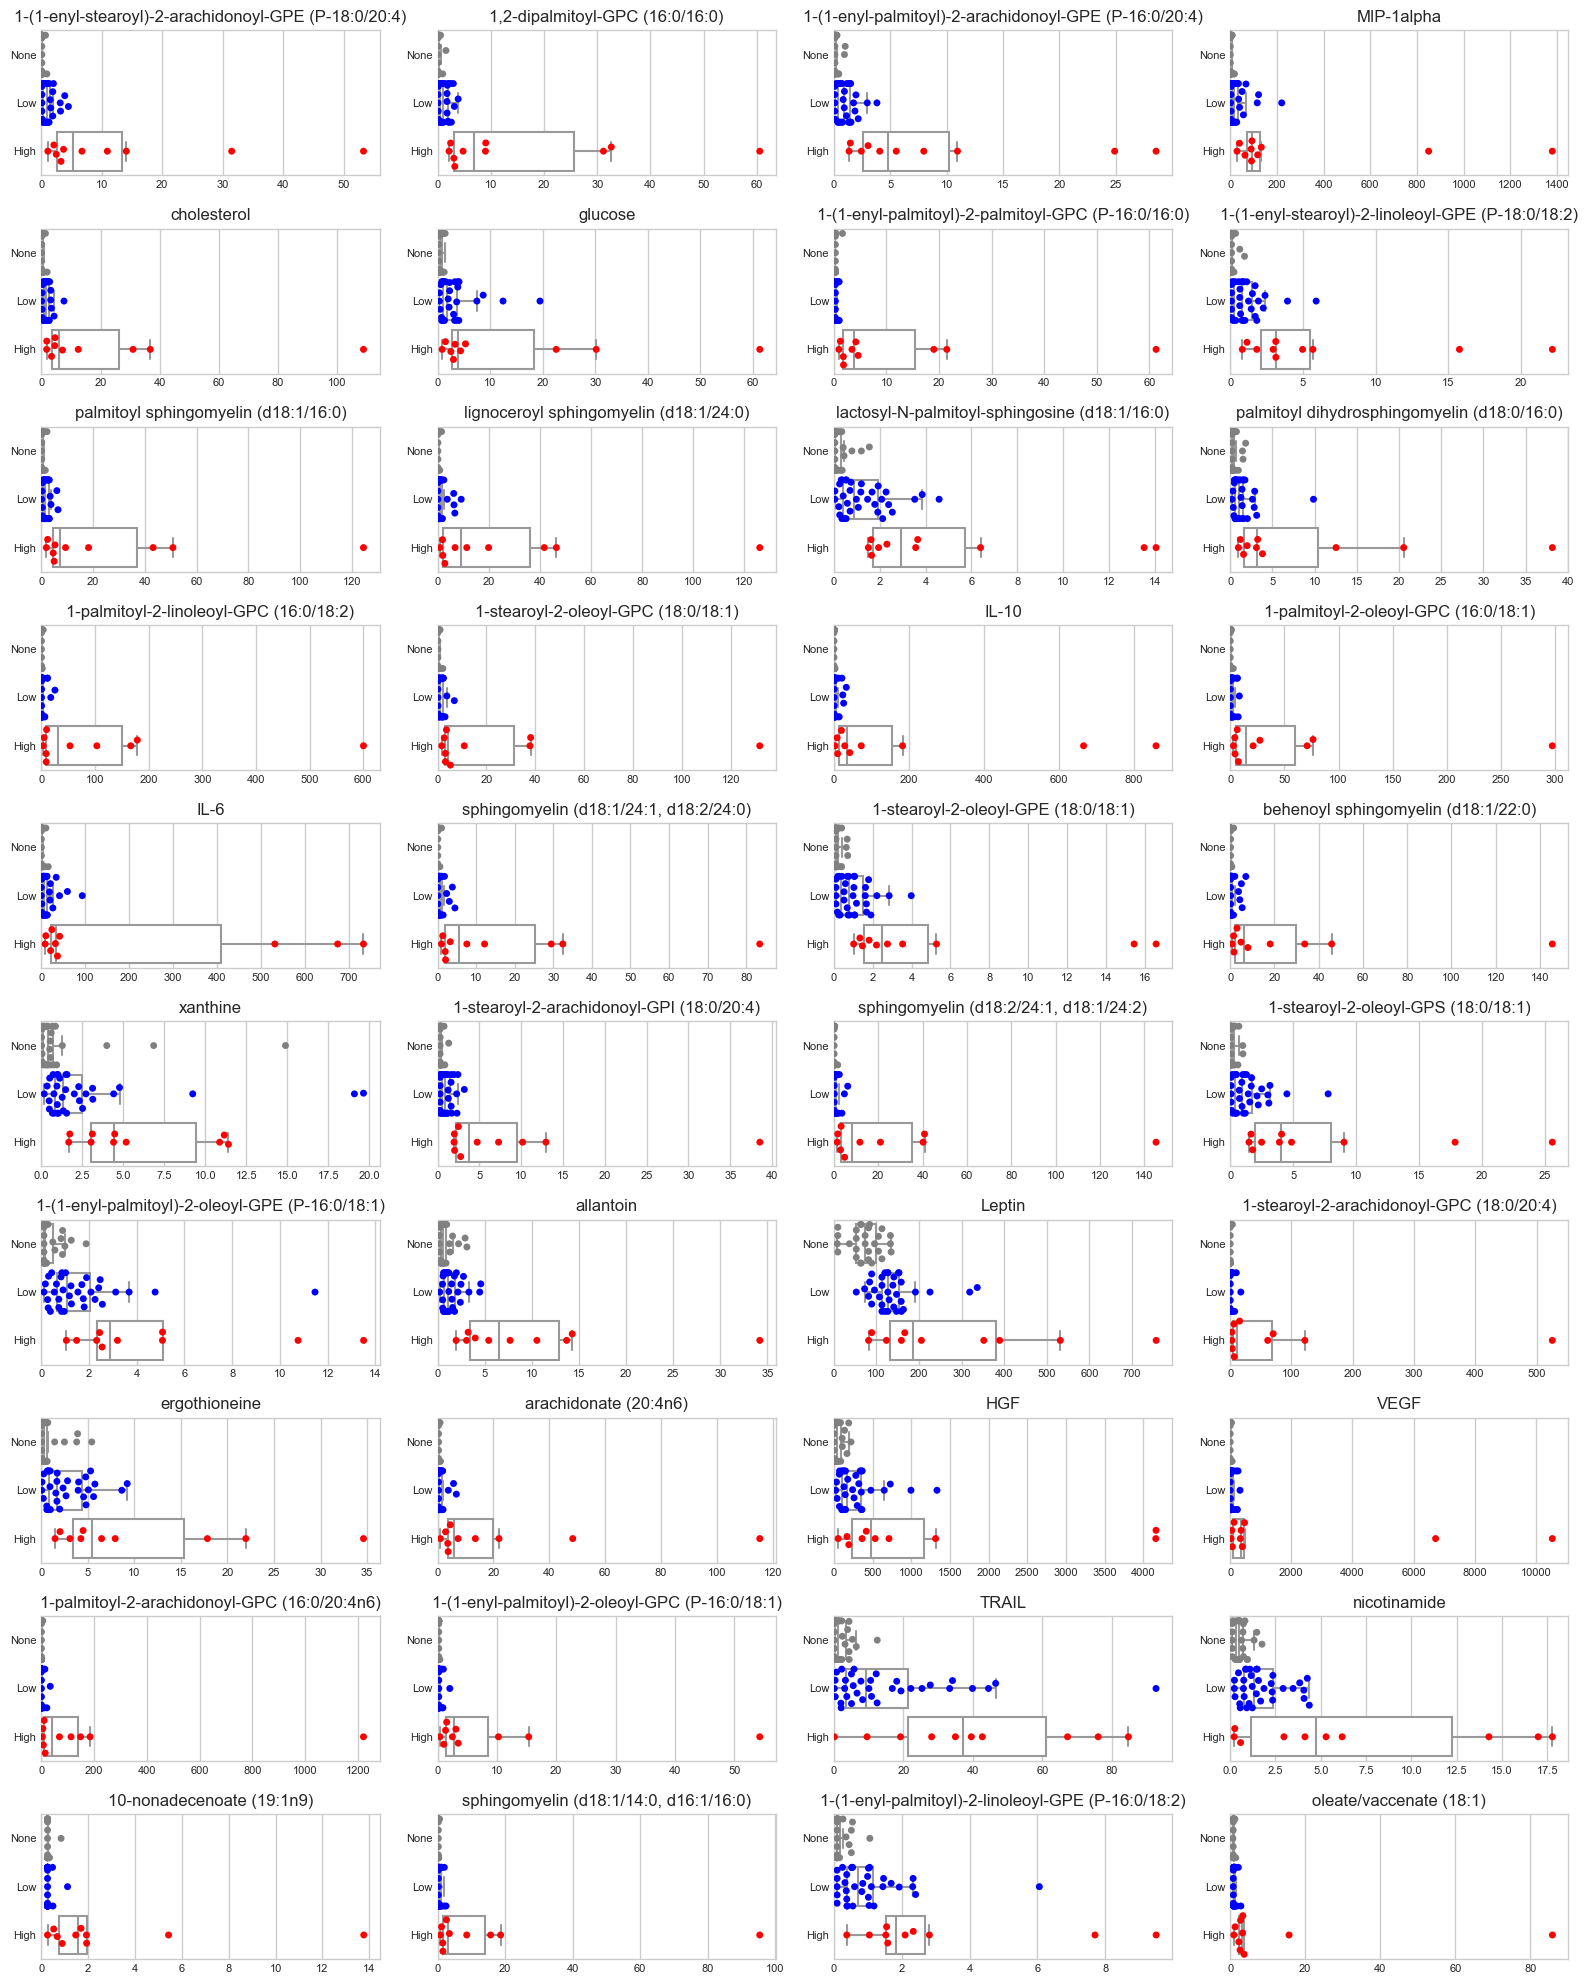

In [20]:
ls_inflammatory_markers = ['CCL20', 'IL-1alpha',
                           'IL-1beta', 'IL-8',
                           'MIP-1beta', 'RAES', 'TNFalpha']
ls_inflammatory_markers = ["F_proteo_" + x for x in ls_inflammatory_markers]
ls_features4inflammation = [x for x in df_data_w_targets_sel.columns if (x.startswith('F_')
                                                                         and x not in ls_inflammatory_markers
                                                                         and not x.startswith('F_pcov_'))]

ls_class_order = ['None', 'Low', 'High']
dic_color_palette = {'None': 'grey', 'Low': 'blue', 'High': 'red'}

train_n_eval_classifier('T_inflammation',
                        ls_features4inflammation,
                        df_data_w_targets_sel,
                        taxa,
                        ls_class_order,
                        dic_color_palette,
                        seed,
                        output_dir)


### Predict `lactobacillus_dominance`


Training classifier for T_lactobacillus_dominance...
Shape of feature table: (72, 535)
['Estimator Accuracy: 0.8589285714285715 ± 0.14295755399732454']

Evaluating combined classifier...
Confusion matrix and ROC curve saved as Q2artifact here: a-modelling-output/classifiers/T_lactobacillus_dominance-accuracy.qzv


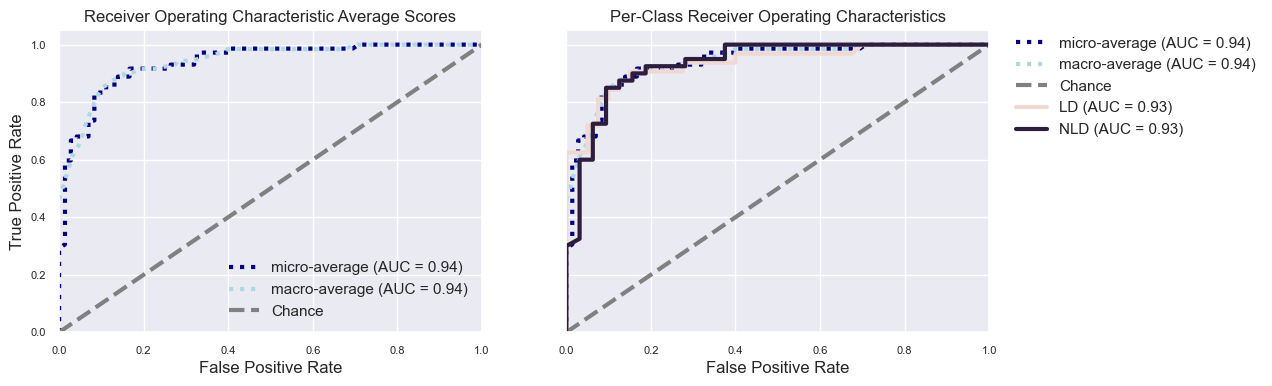

<Figure size 600x400 with 0 Axes>

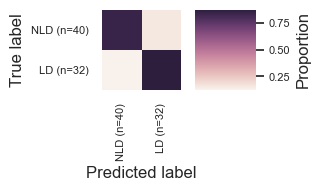

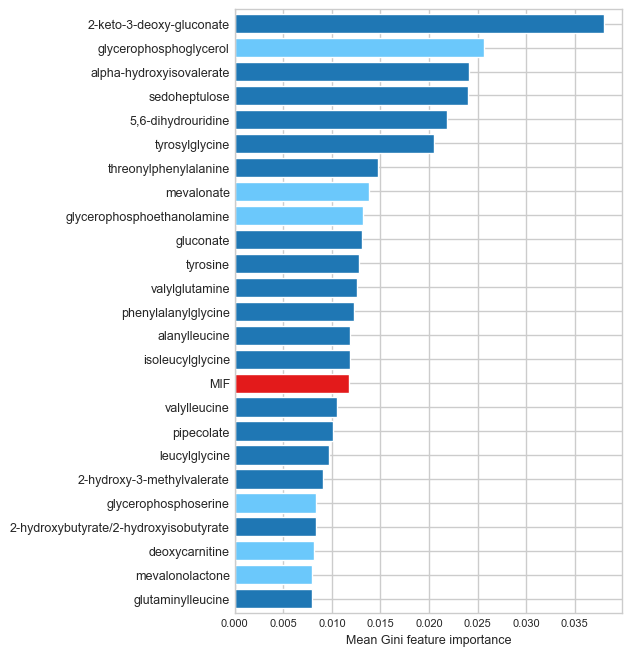


Evaluating separate-omics classifiers...
Metabolome - Number of features: 467
['Estimator Accuracy: 0.8857142857142858 ± 0.13997084244475305']
Immunoproteome - Number of features: 68
['Estimator Accuracy: 0.8035714285714285 ± 0.11627728997214076']


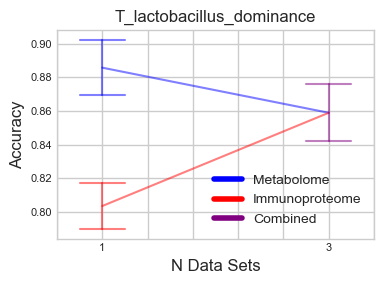

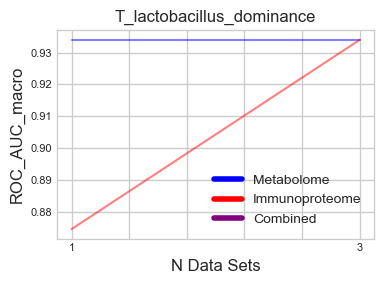

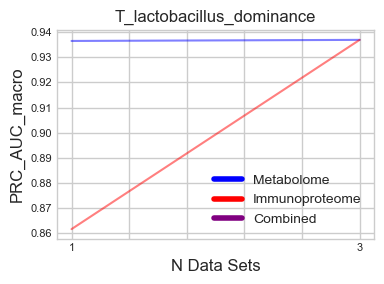


Evaluating feature abundances for combined classifier...


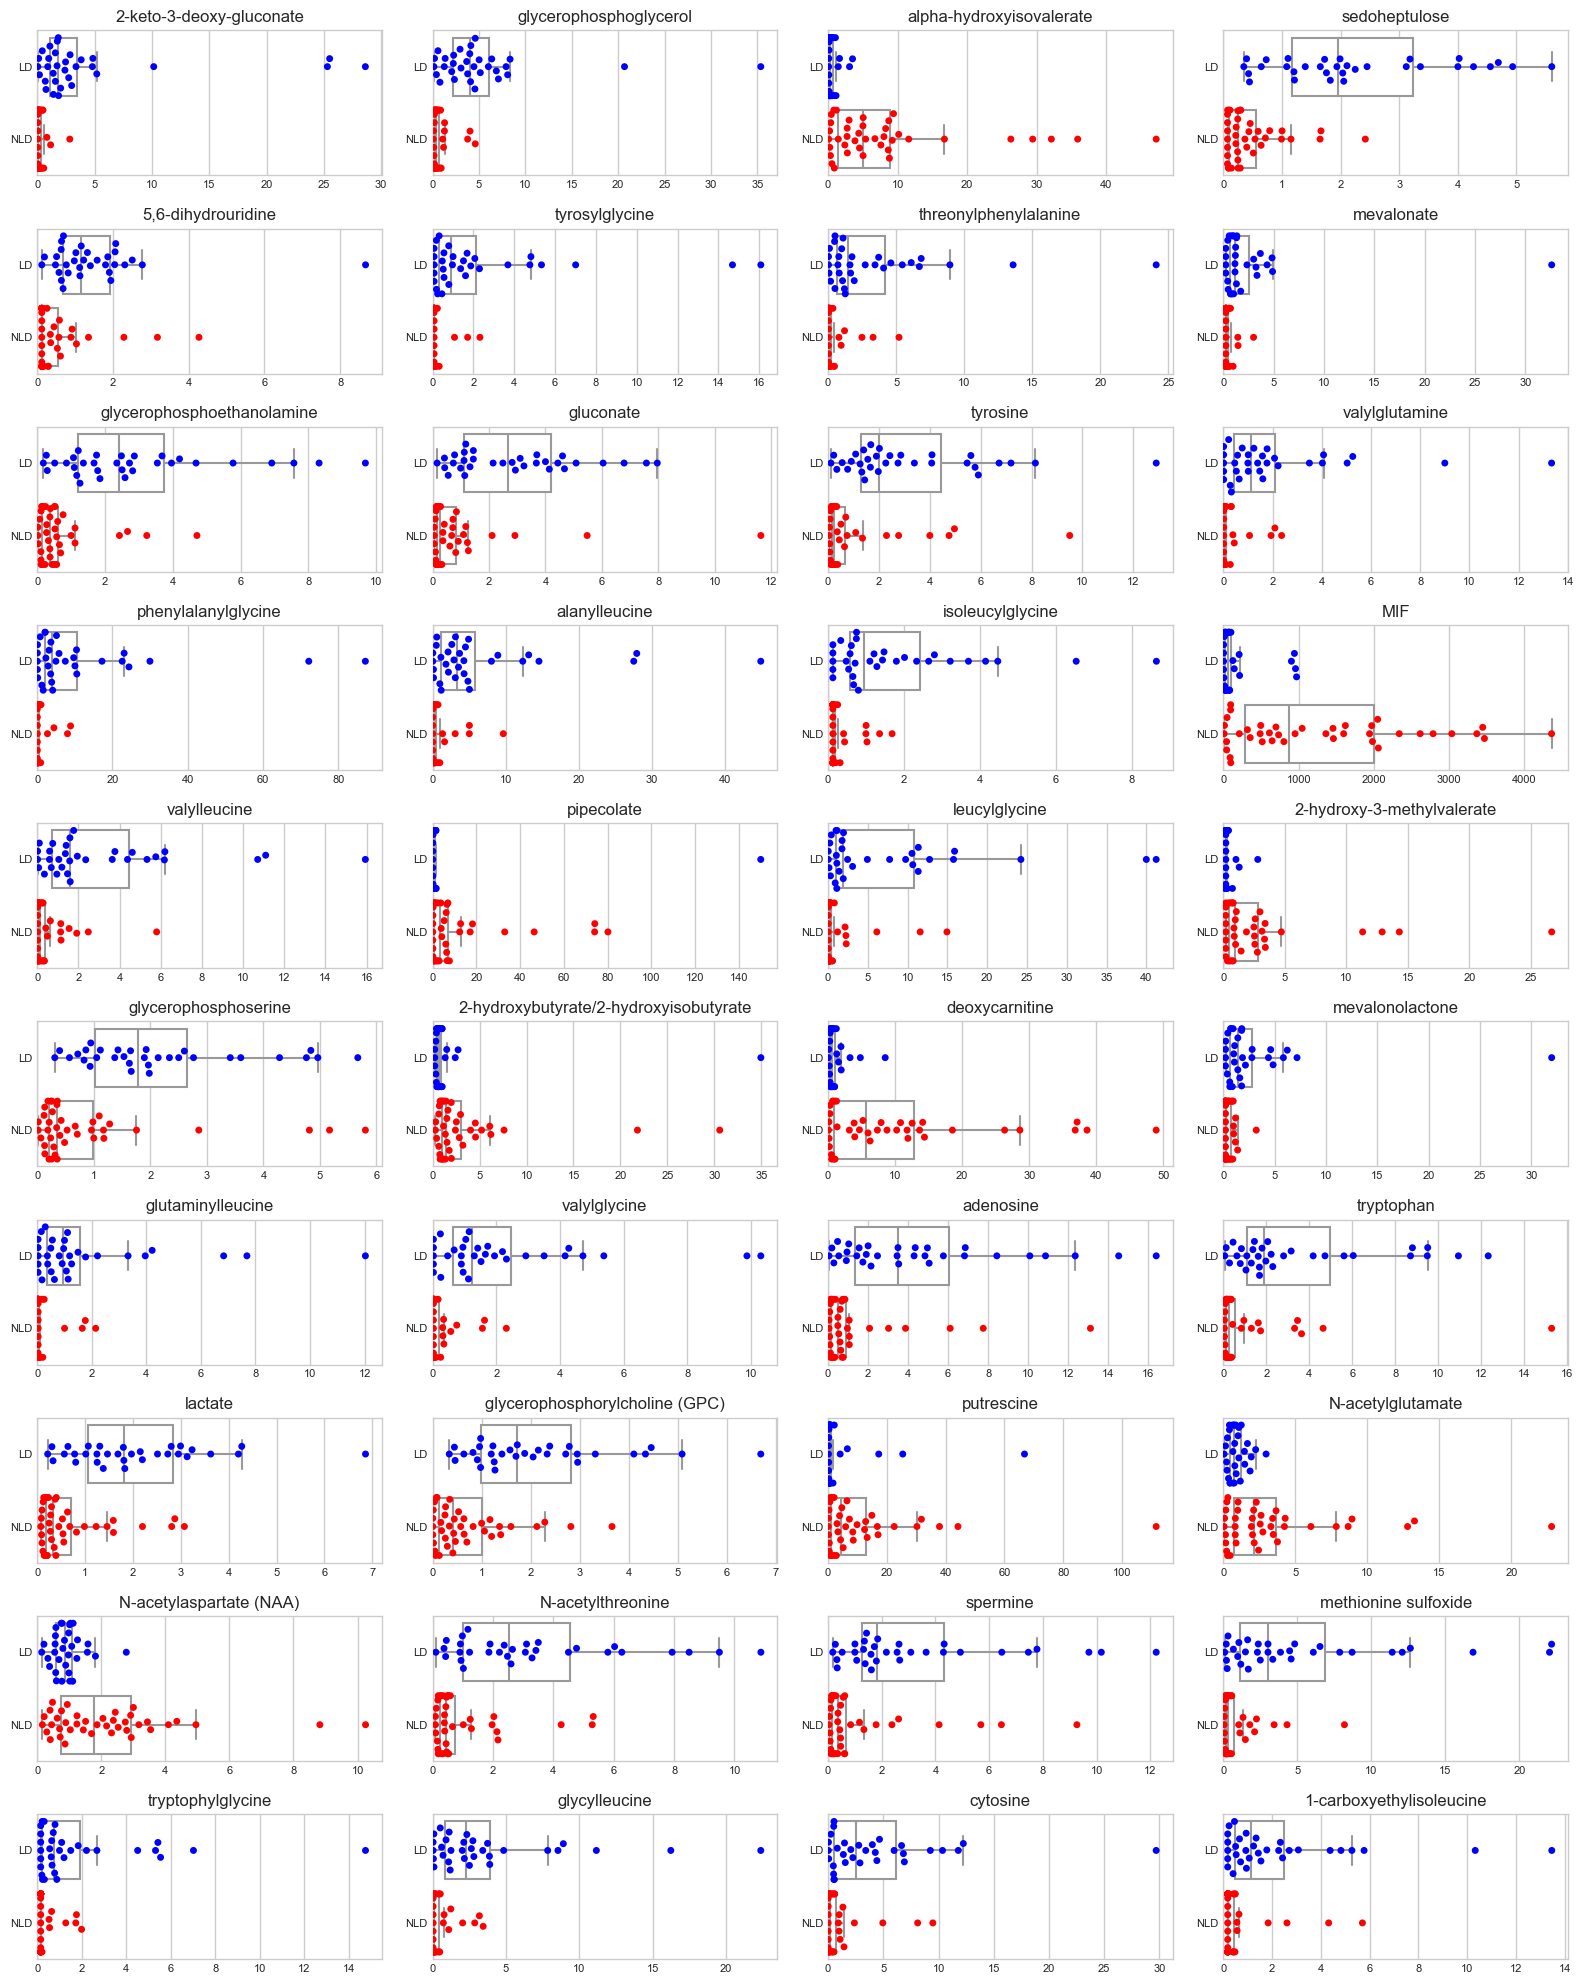

In [21]:
ls_features4lacto = [x for x in df_data_w_targets_sel.columns if
                     (x.startswith('F_metabo_') or x.startswith('F_proteo_'))]

ls_class_order=['LD', 'NLD']
dic_color_palette={'LD': 'blue', 'NLD': 'red'}

train_n_eval_classifier('T_lactobacillus_dominance',
                        ls_features4lacto,
                        df_data_w_targets_sel,
                        taxa,
                        ls_class_order,
                        dic_color_palette,
                        seed,
                        output_dir)

### Predict `vaginal_pH`


Training classifier for T_pH...
Shape of feature table: (72, 1298)
['Estimator Accuracy: 0.7767857142857142 ± 0.13104028434969522']

Evaluating combined classifier...
Confusion matrix and ROC curve saved as Q2artifact here: a-modelling-output/classifiers/T_pH-accuracy.qzv


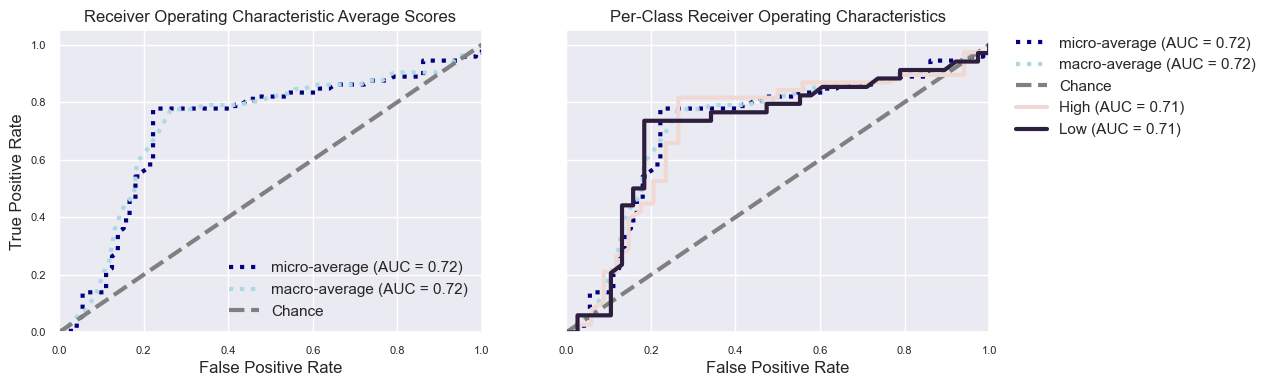

<Figure size 600x400 with 0 Axes>

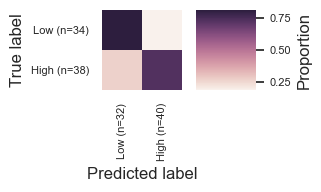

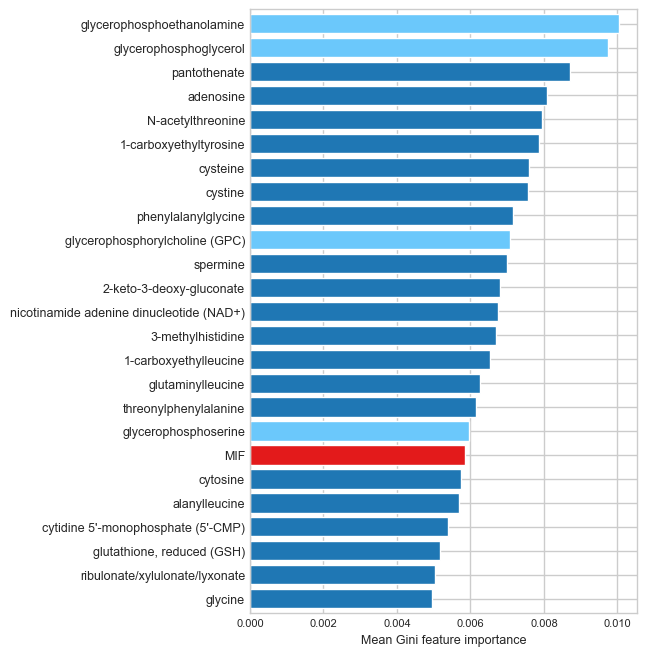


Evaluating separate-omics classifiers...
Microbiome - Number of features: 763
['Estimator Accuracy: 0.6964285714285714 ± 0.15750769336571388']
Metabolome - Number of features: 467
['Estimator Accuracy: 0.7339285714285714 ± 0.1757727109603972']
Immunoproteome - Number of features: 68
['Estimator Accuracy: 0.7107142857142856 ± 0.16478959992941897']


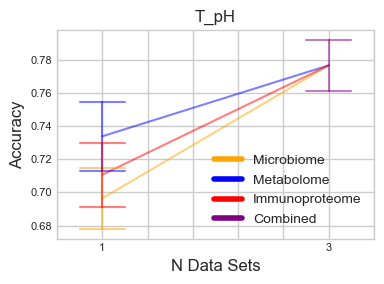

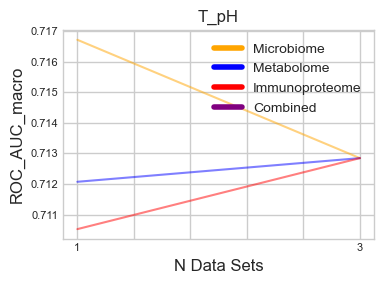

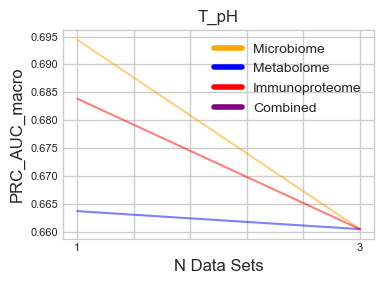


Evaluating feature abundances for combined classifier...


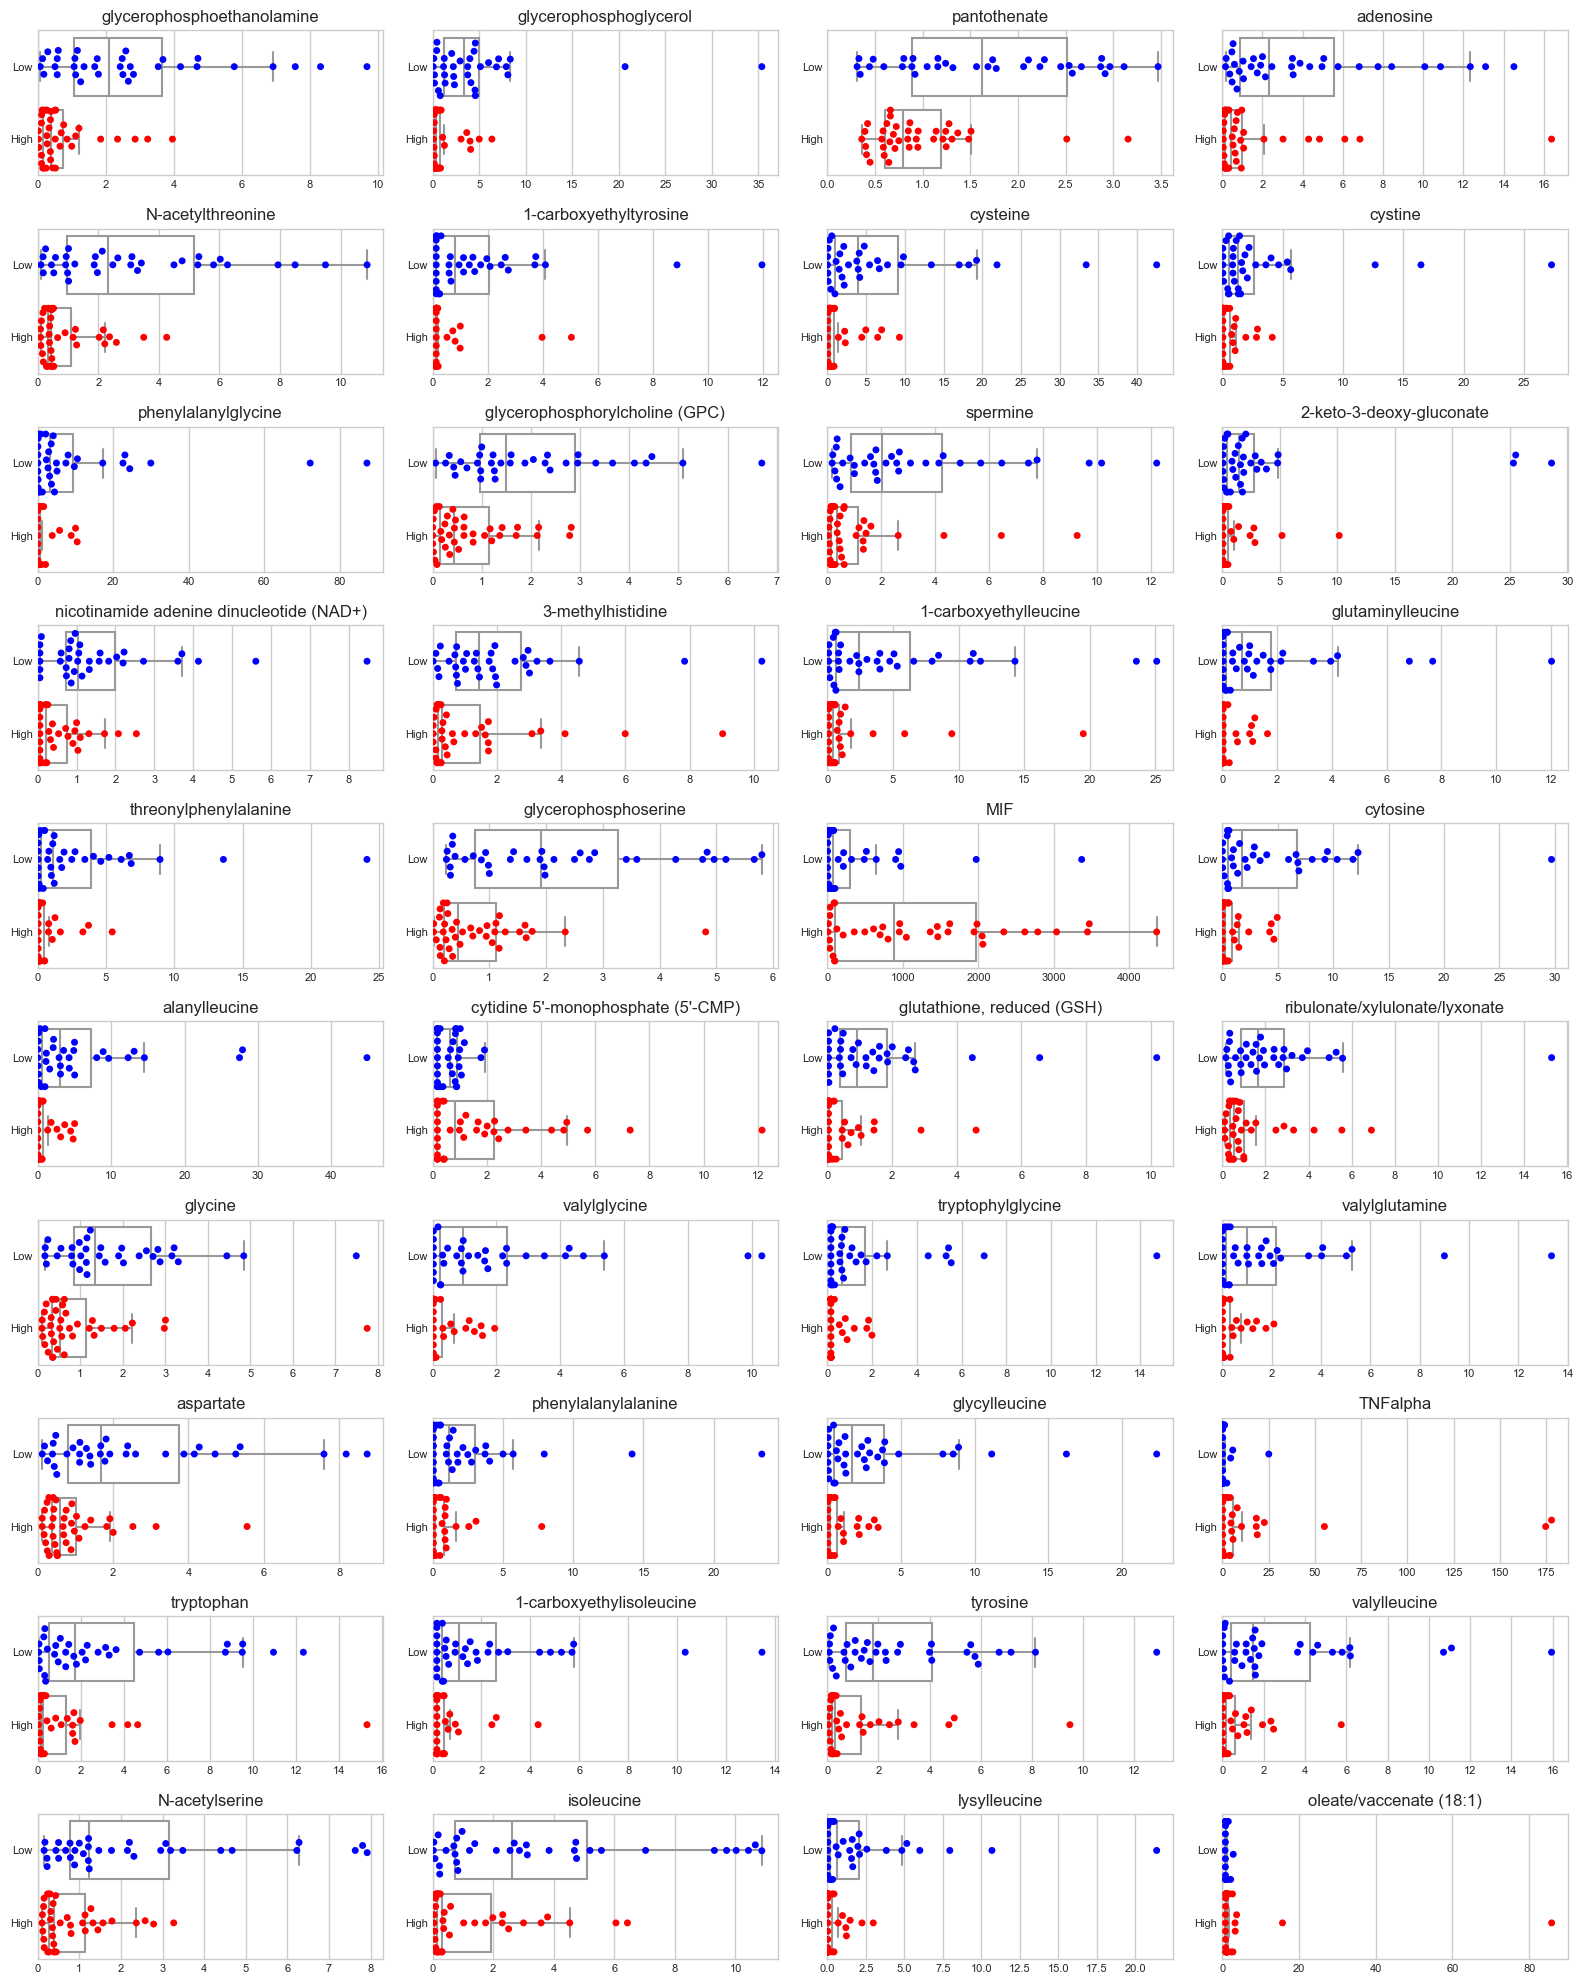

In [22]:
ls_features4ph = [x for x in df_data_w_targets_sel.columns if
                  ((x.startswith('F_') and not x.startswith('F_pcov_')))]

ls_class_order=['Low', 'High']
dic_color_palette={'Low': 'blue', 'High': 'red'}

train_n_eval_classifier('T_pH',
                        ls_features4ph,
                        df_data_w_targets_sel,
                        taxa,
                        ls_class_order,
                        dic_color_palette,
                        seed,
                        output_dir)


<a id='chap5'></a>

## 5) Train and evaluate regressors

### Predict `metabolites`


Training regressors for 94 number of metabolites...
Estimator Accuracy: 0.7668683546916916 ± 1.1934340406378765
Estimator Accuracy: 1.003933083906637 ± 0.4764660056812674
Estimator Accuracy: 0.7718302374745696 ± 0.5874914364420959
Estimator Accuracy: 1.0515236134032868 ± 0.4943649525502953
Estimator Accuracy: 2.164406536139461 ± 1.572073434415579
Estimator Accuracy: 0.9905626865984782 ± 0.3985904648585395
Estimator Accuracy: 0.30743280950312407 ± 0.37966639535850794
Estimator Accuracy: 0.47242178307907085 ± 0.5691625133545122
Estimator Accuracy: 0.4226668980622824 ± 0.2336263411612661
Estimator Accuracy: 1.346271424357972 ± 0.7670496599643707
Estimator Accuracy: 0.569211211319055 ± 0.5591899734375058
Estimator Accuracy: 0.7656231379038193 ± 0.6043389604338578
Estimator Accuracy: 0.6104573593227064 ± 0.5850255844609765
Estimator Accuracy: 0.3853081395076621 ± 0.2983227251118225
Estimator Accuracy: 0.7567703798731236 ± 0.5390979063664945
Estimator Accuracy: 0.7631017700256042 ± 0.829248

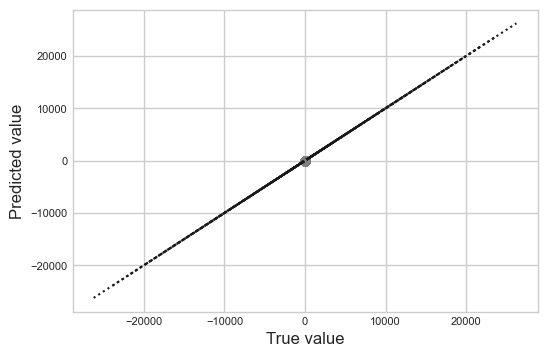

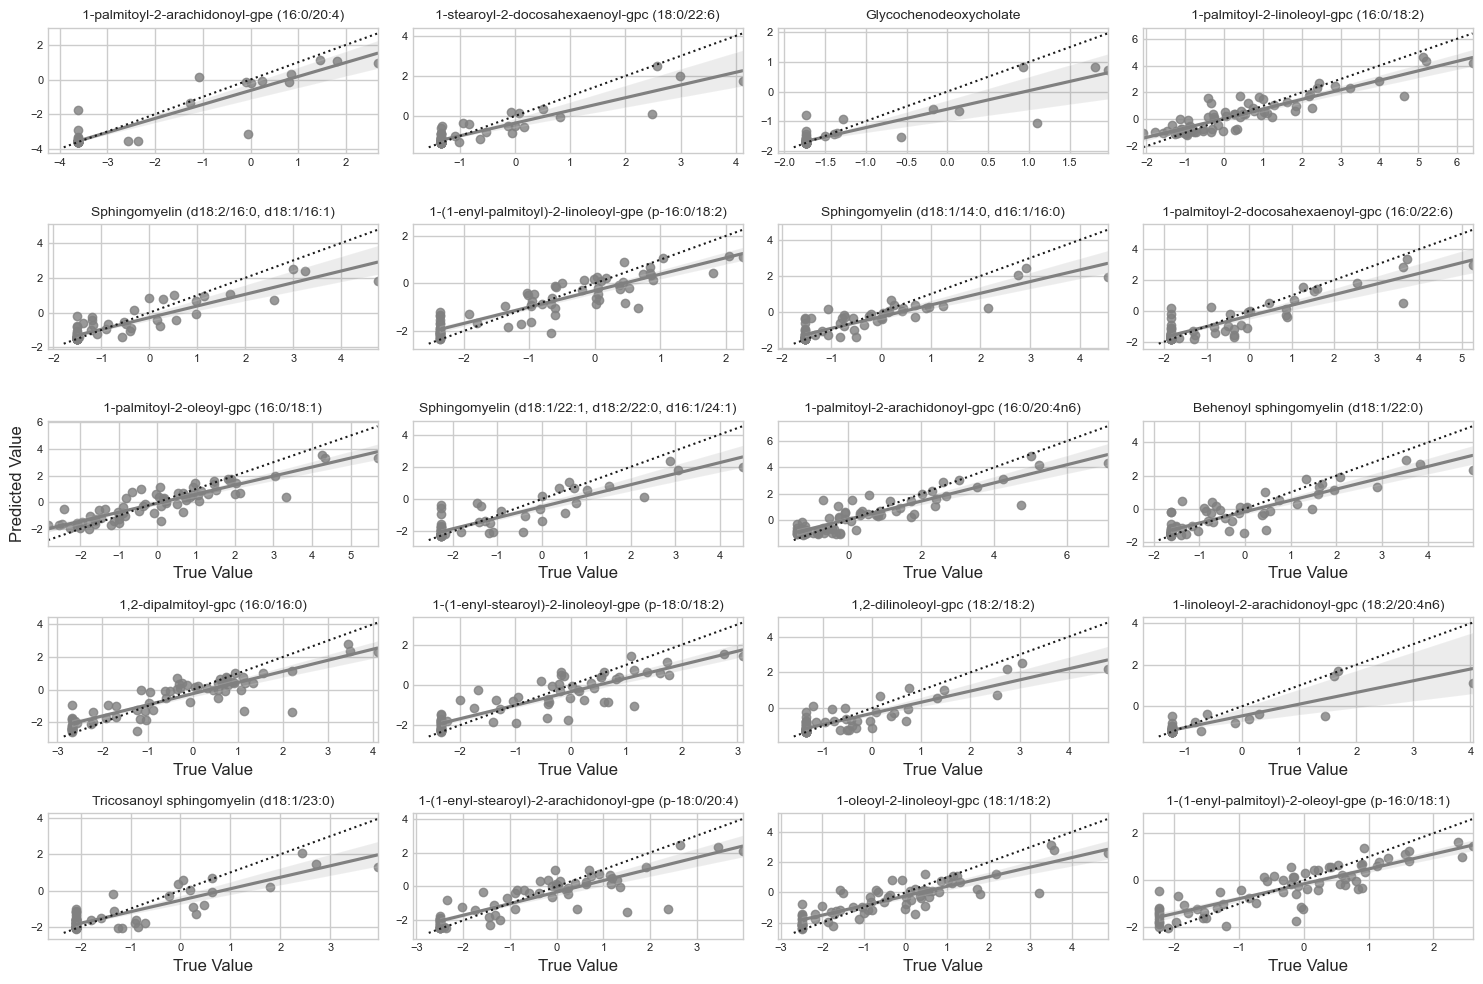

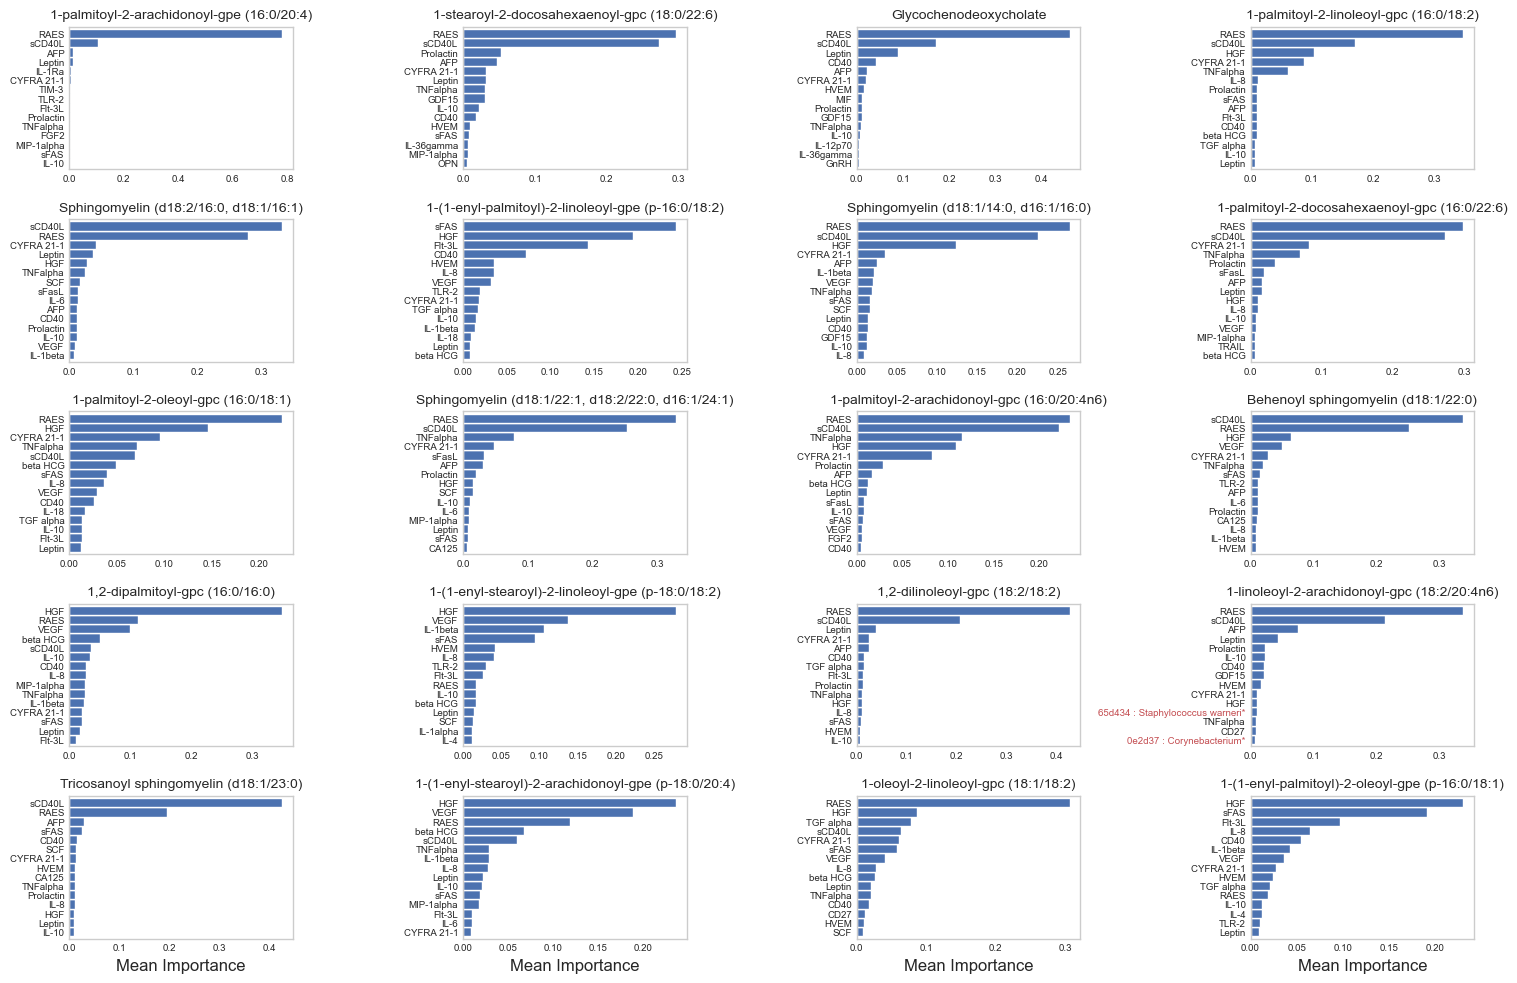

In [23]:
# features
ls_features_metabolites = [x for x in df_data_w_targets_sel.columns if
                           ((x.startswith('F_micro_') or x.startswith('F_proteo_')))]

# targets: 94 selected metabolites
ls_targets_metabolites = list(set([
    '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)',
    '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)',
    '1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)',
    '1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)',
    '1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)',
    '1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)',
    '1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)',
    '1-(1-enyl-stearoyl)-2-linoleoyl-GPE (P-18:0/18:2)',
    '1-(1-enyl-stearoyl)-2-oleoyl-GPE (P-18:0/18:1)',
    '3-indoxyl sulfate',
    '4-acetamidobutanoate',
    '5-methylthioadenosine (MTA)',
    'agmatine',
    'arachidonate (20:4n6)',
    'C-glycosyltryptophan',
    'diacetylspermidine',
    'dihomo-linolenate (20:3n3 or n6)',
    'glycochenodeoxycholate',
    'indolelactate',
    'kynurenate',
    'kynurenine',
    'linoleate (18:2n6)',
    'linolenate [alpha or gamma; (18:3n3 or 6)]',
    "N('1)-acetylspermidine",
    'N(1)-acetylspermine',
    'N1,N12-diacetylspermine',
    'N-acetyl-isoputreanine',
    'N-acetylputrescine',
    'putrescine',
    'spermidine',
    'spermine',
    'tryptamine',
    'tryptophan',
    'tryptophan betaine',
    '2-hydroxyhippurate (salicylurate)',
    '3-hydroxyhippurate',
    '4-hydroxyhippurate',
    'hippurate',
    'oleate/vaccenate (18:1)',
    'histamine',
    '1-methylhistamine',
    'tryptamine',
    'tyramine',
    'agmatine',
    'cadaverine',
    'N-acetyl-cadaverine',
    'N-acetylputrescine',
    'putrescine',
    'diacetylspermidine',
    "N('1)-acetylspermidine",
    'N(1)-acetylspermine',
    'N1,N12-diacetylspermine',
    'spermidine',
    'spermine',
    '1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)',
    '1,2-dilinoleoyl-GPC (18:2/18:2)', '1,2-dipalmitoyl-GPC (16:0/16:0)',
    '1-linoleoyl-2-arachidonoyl-GPC (18:2/20:4n6)',
    '1-linoleoyl-GPC (18:2)', '1-oleoyl-2-linoleoyl-GPC (18:1/18:2)',
    '1-oleoyl-GPC (18:1)', '1-palmitoyl-2-arachidonoyl-GPC (16:0/20:4n6)',
    '1-palmitoyl-2-arachidonoyl-GPE (16:0/20:4)',
    '1-palmitoyl-2-docosahexaenoyl-GPC (16:0/22:6)',
    '1-palmitoyl-2-linoleoyl-GPC (16:0/18:2)',
    '1-palmitoyl-2-oleoyl-GPC (16:0/18:1)',
    '1-palmitoyl-2-palmitoleoyl-GPC (16:0/16:1)', '1-palmitoyl-GPC (16:0)',
    '1-stearoyl-2-arachidonoyl-GPC (18:0/20:4)',
    '1-stearoyl-2-docosahexaenoyl-GPC (18:0/22:6)',
    '1-stearoyl-2-oleoyl-GPC (18:0/18:1)', '1-stearoyl-GPC (18:0)',
    '2-hydroxyhippurate (salicylurate)', '3-hydroxybutyrate (BHBA)',
    'behenoyl sphingomyelin (d18:1/22:0)', 'cefazolin', 'cholesterol',
    'cytosine', 'deoxycarnitine', 'glutathione, oxidized (GSSG)',
    'glycerol', 'glycerophosphoglycerol', 'imidazole propionate',
    "inosine 5'-monophosphate (IMP)",
    # 'lamotrigine',  # excluded during feature processing (all values were the same: stddev = 0.0)
    'linolenate [alpha or gamma; (18:3n3 or 6)]', 'maltopentaose',
    'mannonate', 'meglumine', 'N-acetyl-cadaverine',
    'N-acetylmethionine sulfoxide', 'N-acetylserine',
    'N-alpha-acetylornithine', 'oleate/vaccenate (18:1)',
    'phenylalanylglycine', 'pipecolate', 'pyroglutamine',
    'sphingomyelin (d18:1/14:0, d16:1/16:0)',
    'sphingomyelin (d18:1/22:1, d18:2/22:0, d16:1/24:1)',
    'sphingomyelin (d18:2/16:0, d18:1/16:1)',
    'tricosanoyl sphingomyelin (d18:1/23:0)', 'tryptamine',
    'eicosenoate (20:1)', 'salicylate',
    'N6-methyllysine',
    'dihomo-linolenate (20:3n3 or n6)',
    'uridine',
    'arachidonate (20:4n6)',
    'dehydroepiandrosterone sulfate (DHEA-S)',
    '2-hydroxypalmitate',
    '10-nonadecenoate (19:1n9)',
    '3-carboxy-4-methyl-5-propyl-2-furanpropanoate (CMPF)',
    'phenylpyruvate']))

# train and eval
train_n_eval_regressors(ls_targets_metabolites,
                        'metabolites',
                        transform_target2log=True,
                        ls_features=ls_features_metabolites,
                        df_data=df_data_w_targets_sel,
                        taxa=taxa,
                        seed=seed,
                        output_dir=output_dir)


### Predict `metabolites` removing cancer cases


Training regressors for 94 number of metabolites_no_cancer...
Estimator Accuracy: 0.7929089744413187 ± 1.3174874649623458
Estimator Accuracy: 0.7649773906337737 ± 0.6846526073653967
Estimator Accuracy: 0.9982789587009793 ± 0.9896715572244991
Estimator Accuracy: 1.1625308110351855 ± 0.4667028606378669
Estimator Accuracy: 1.8317778143082672 ± 1.5314104686735193
Estimator Accuracy: 1.1146179638503595 ± 0.5056604512636097
Estimator Accuracy: 0.16943910547236823 ± 0.19942415524630075
Estimator Accuracy: 0.23120264909487523 ± 0.22134891434813467
Estimator Accuracy: 0.3512466116715727 ± 0.1661382075525729
Estimator Accuracy: 1.311018536586217 ± 0.5439698607516202
Estimator Accuracy: 0.5569218358395343 ± 0.7511818660795788
Estimator Accuracy: 0.8078069741196285 ± 0.6135430412723774
Estimator Accuracy: 0.41287788819763627 ± 0.3591453166991448
Estimator Accuracy: 0.2715820680694047 ± 0.2951366688924791
Estimator Accuracy: 0.901693123314098 ± 0.3900570908031854
Estimator Accuracy: 0.682755248063

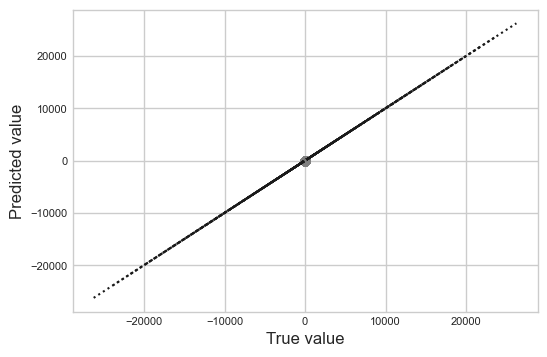

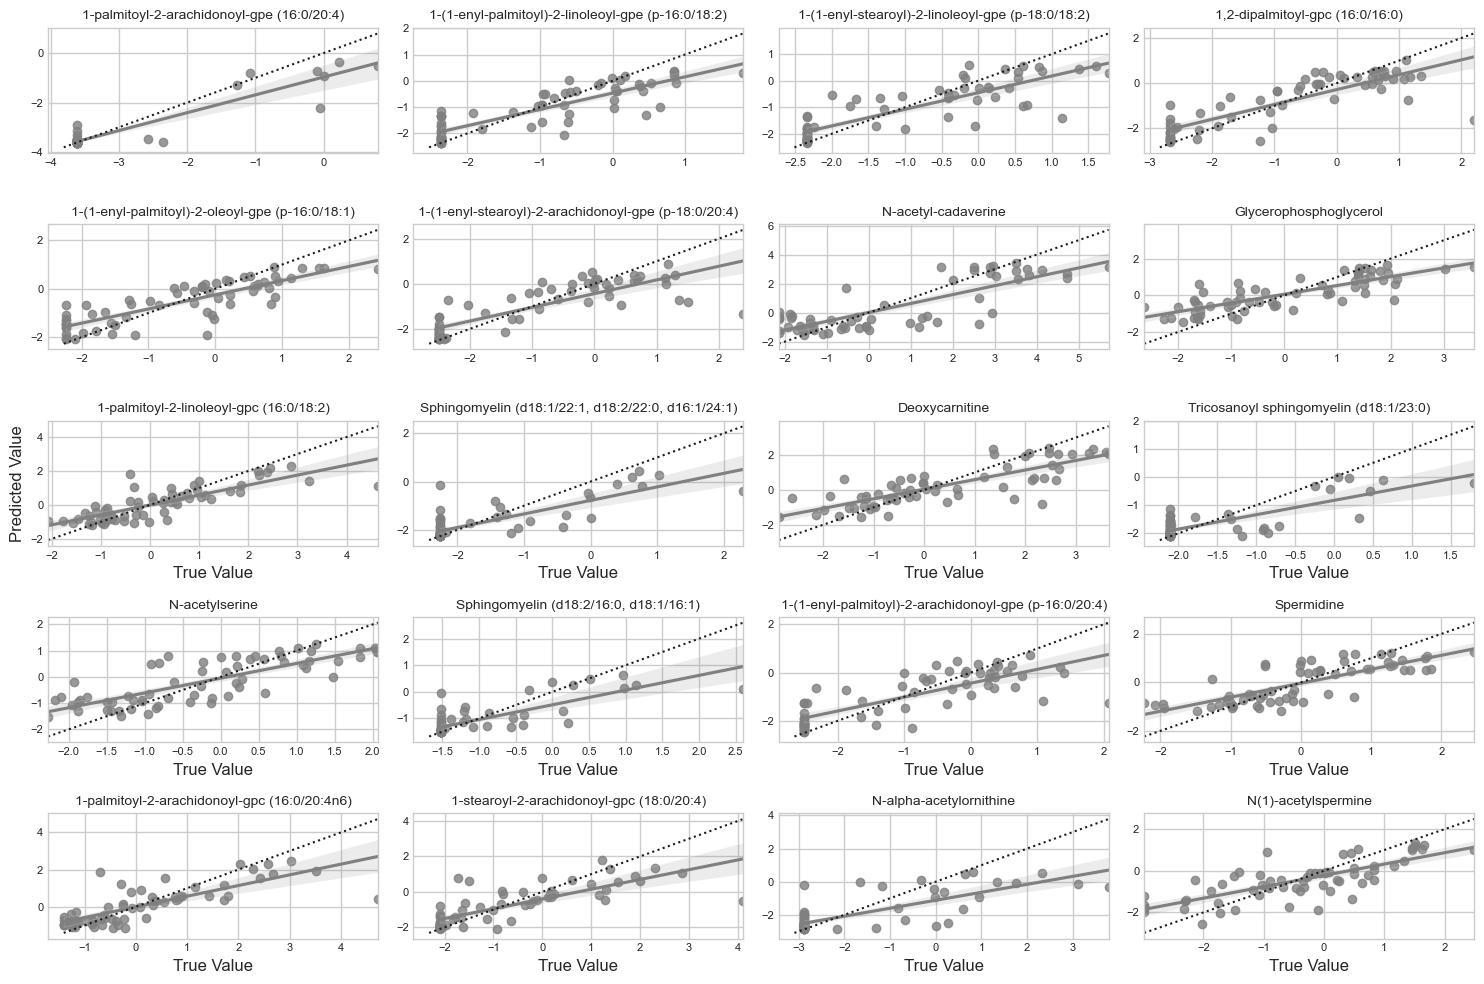

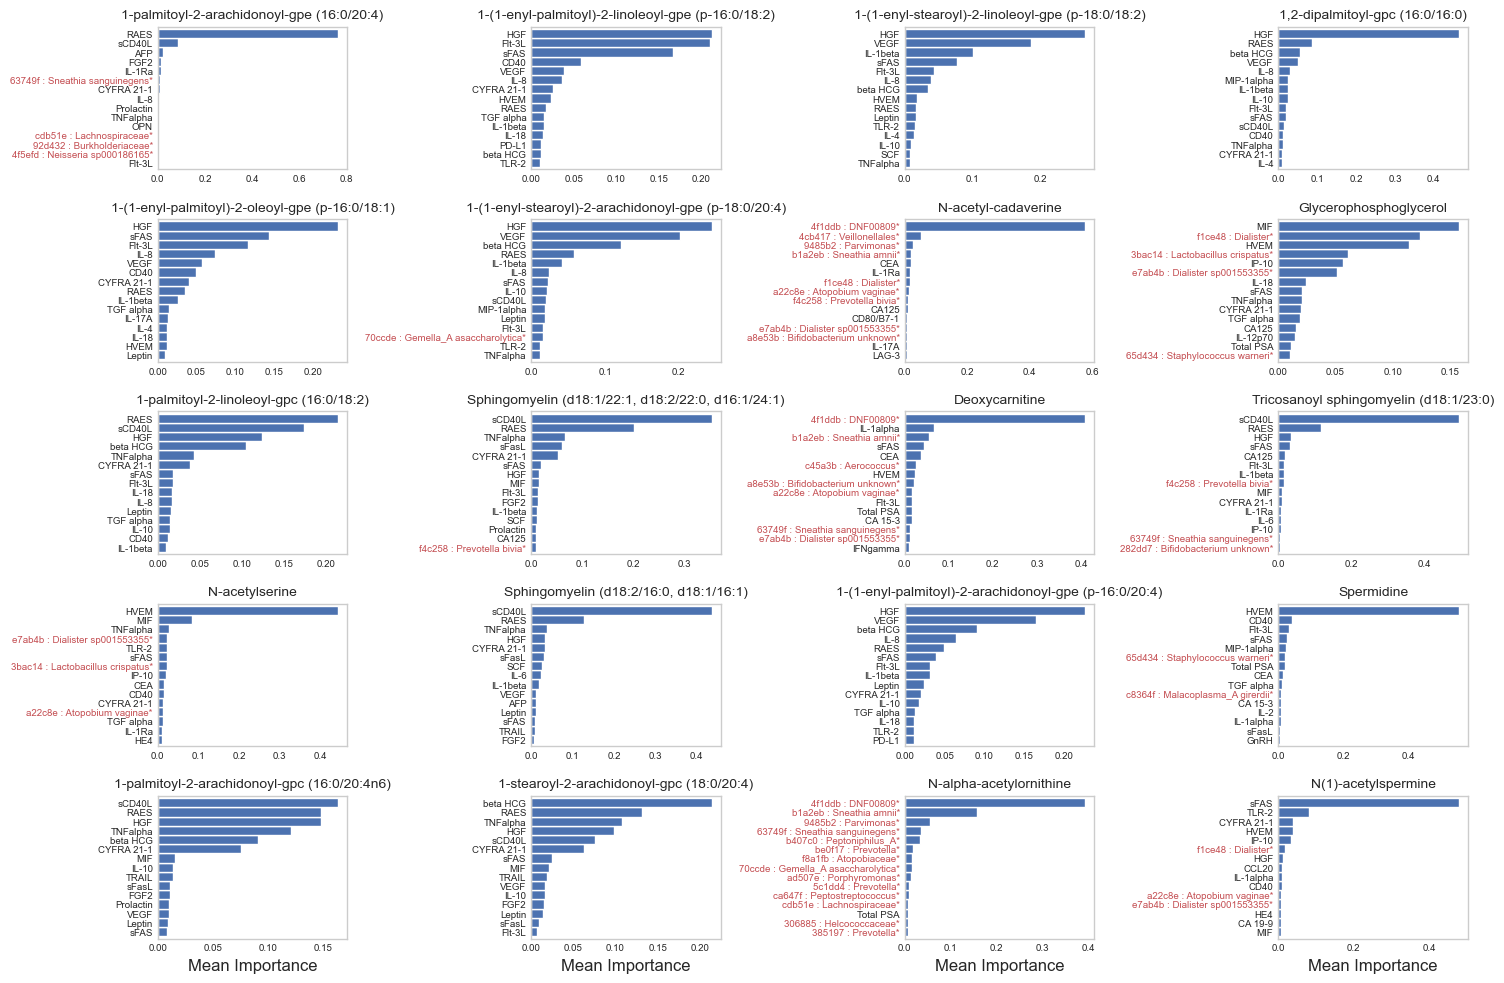

In [24]:
df_data_wo_cancer = df_data_w_targets_sel[df_data_w_targets_sel['T_disease_state'] != 'ICC'].copy(
    deep=True)

# same features as before
# train and eval
train_n_eval_regressors(ls_targets_metabolites,
                        'metabolites_no_cancer',
                        transform_target2log=True,
                        ls_features=ls_features_metabolites,
                        df_data=df_data_wo_cancer,
                        taxa=taxa,
                        seed=seed,
                        output_dir=output_dir)


### Predict `biomarkers`


Training regressors for 44 number of biomarkers...
Estimator Accuracy: 0.8437966407397484 ± 0.5002638752860765
Estimator Accuracy: 1.0505645872985534 ± 0.7398522894691862
Estimator Accuracy: 1.8094077790488536 ± 0.7769190389901699
Estimator Accuracy: 1.1891837404806445 ± 0.6065580315227208
Estimator Accuracy: 1.5748310561758516 ± 0.6884888418253094
Estimator Accuracy: 0.5041613358343083 ± 0.19031781219544125
Estimator Accuracy: 1.512842115716264 ± 0.716823792333794
Estimator Accuracy: 0.6388374387539011 ± 0.3961997909703176
Estimator Accuracy: 1.2214416274323452 ± 0.7242598992850323
Estimator Accuracy: 0.8656833980152749 ± 0.17193723219501272
Estimator Accuracy: 1.0238272292990835 ± 0.393440478958158
Estimator Accuracy: 1.5662490494636006 ± 0.6868236958543184
Estimator Accuracy: 1.1863956772607458 ± 0.49367401358625435
Estimator Accuracy: 0.22431793368998193 ± 0.18296724568272116
Estimator Accuracy: 1.7439705896326436 ± 0.6682242387527376
Estimator Accuracy: 1.2349729497448618 ± 0.868

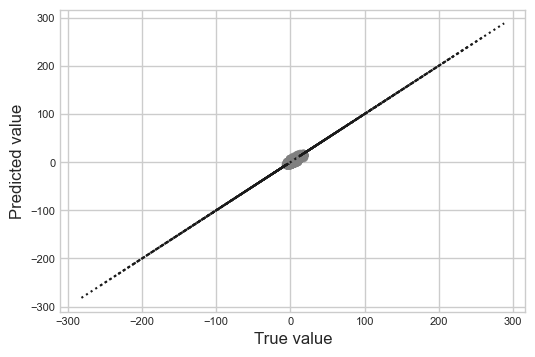

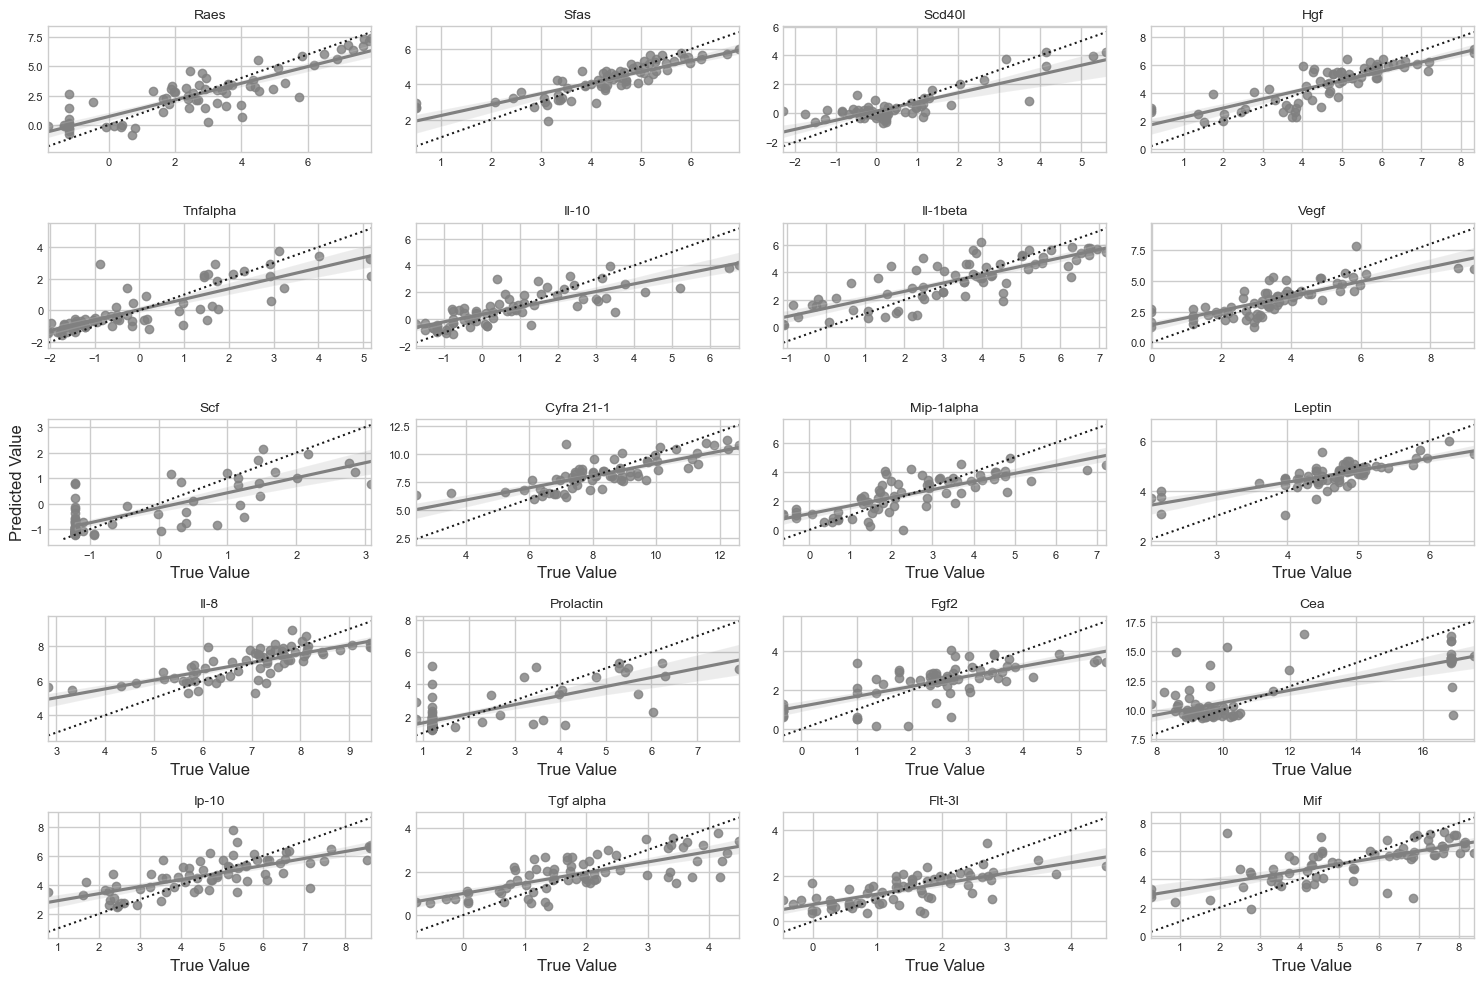

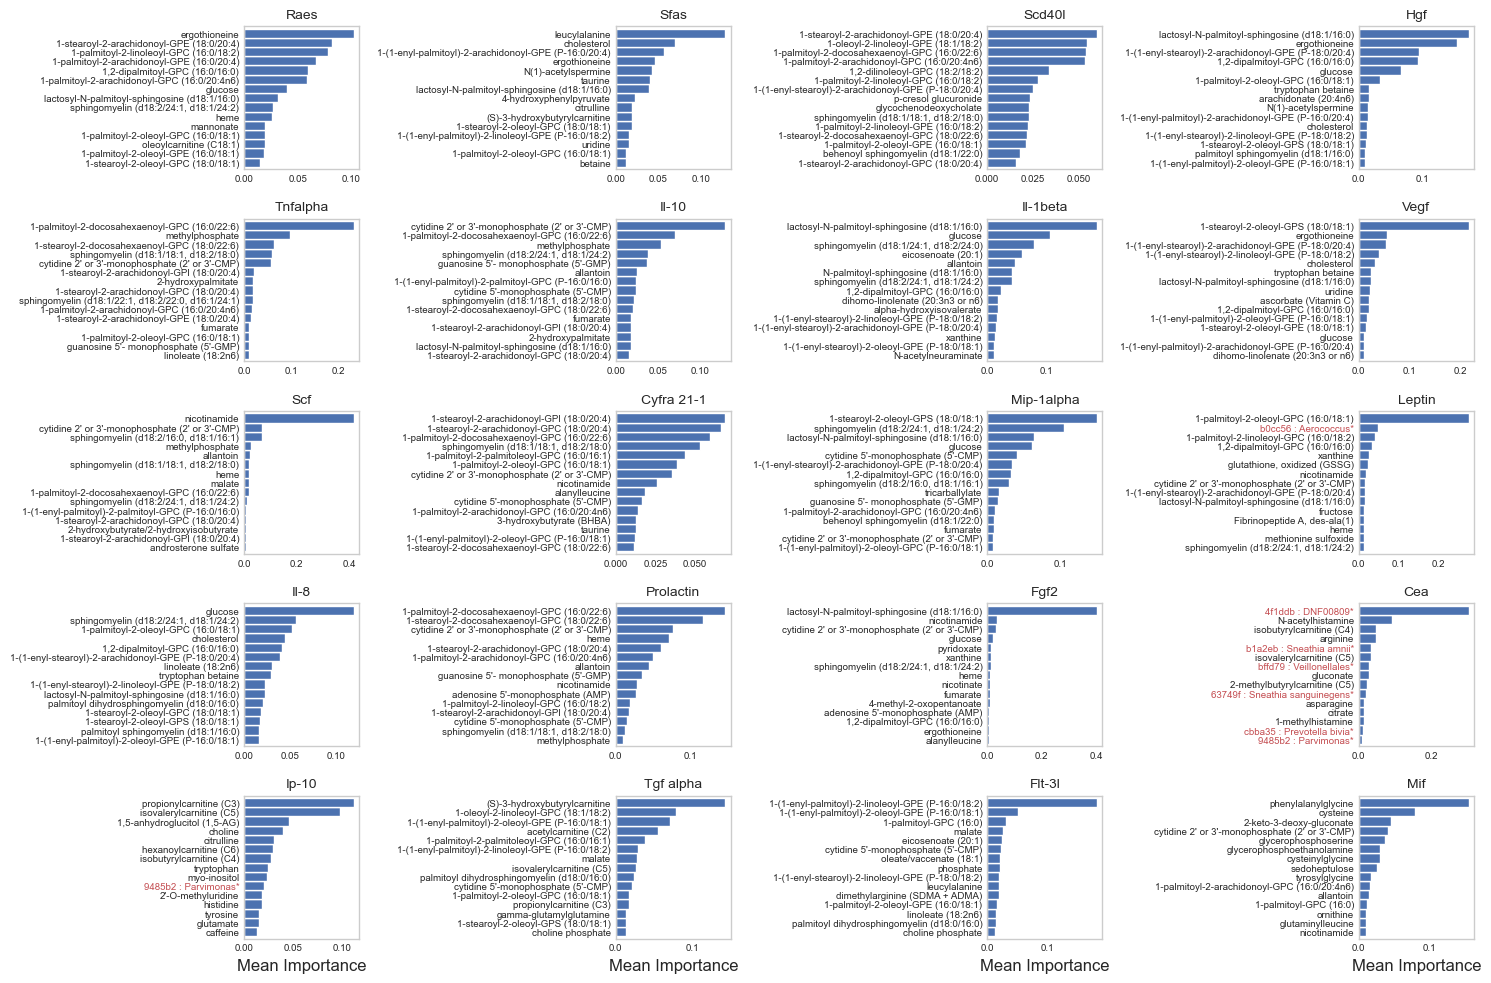

In [25]:
# features
ls_features_biomarkers = [x for x in df_data_w_targets_sel.columns if
                           ((x.startswith('F_micro_') or x.startswith('F_metabo_')))]

# targets were defined at the start when reading in the list ls_cancer_biomarkers

# train and eval
train_n_eval_regressors(ls_cancer_biomarkers,
                        'biomarkers',
                        transform_target2log=True,
                        ls_features=ls_features_biomarkers,
                        df_data=df_data_w_targets_sel,
                        taxa=taxa,
                        seed=seed,
                        output_dir=output_dir)

### Predict `biomarkers` removing cancer cases


Training regressors for 44 number of biomarkers_no_cancer...
Estimator Accuracy: 0.8484596222884587 ± 0.5402512106066405
Estimator Accuracy: 0.8668212478652659 ± 0.5654718266554337
Estimator Accuracy: 1.965821384474678 ± 1.6716792530404547
Estimator Accuracy: 1.0659739408447026 ± 0.681009921611772
Estimator Accuracy: 1.6506331322351222 ± 1.0272437501431162
Estimator Accuracy: 0.40046346508195185 ± 0.19803522683345526
Estimator Accuracy: 1.3890578799311266 ± 0.7246434664146278
Estimator Accuracy: 0.6458815586046631 ± 0.35596092371012295
Estimator Accuracy: 0.9011539660463287 ± 0.6038689121824022
Estimator Accuracy: 0.8049861917207588 ± 0.2720845407829252
Estimator Accuracy: 1.0692062262393822 ± 0.41002881024535287
Estimator Accuracy: 1.4556954828808022 ± 0.7897962135506417
Estimator Accuracy: 1.1100511242022537 ± 0.5671113670506914
Estimator Accuracy: 0.24283318347878646 ± 0.16162251739749176
Estimator Accuracy: 1.6789501840270549 ± 0.5623064459501794
Estimator Accuracy: 1.347594328407

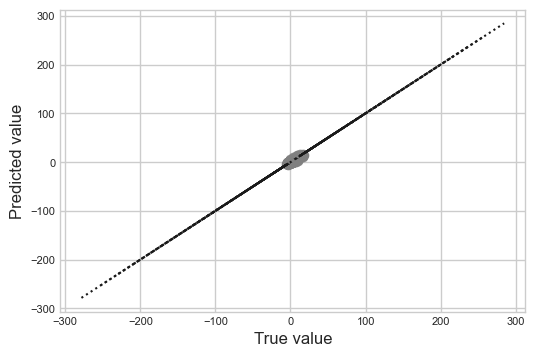

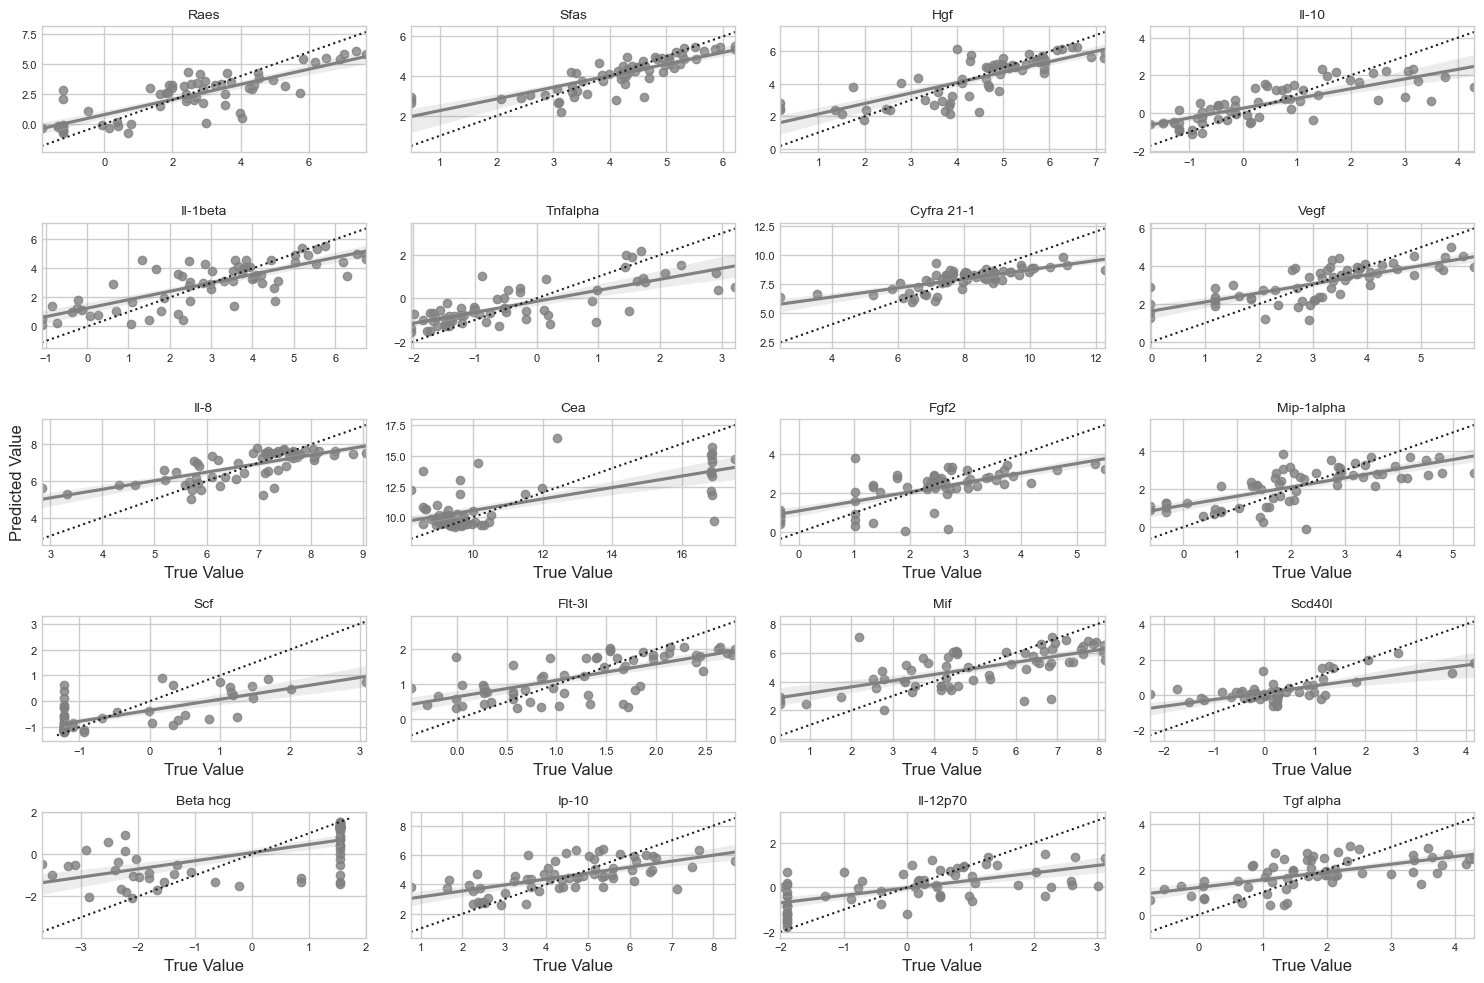

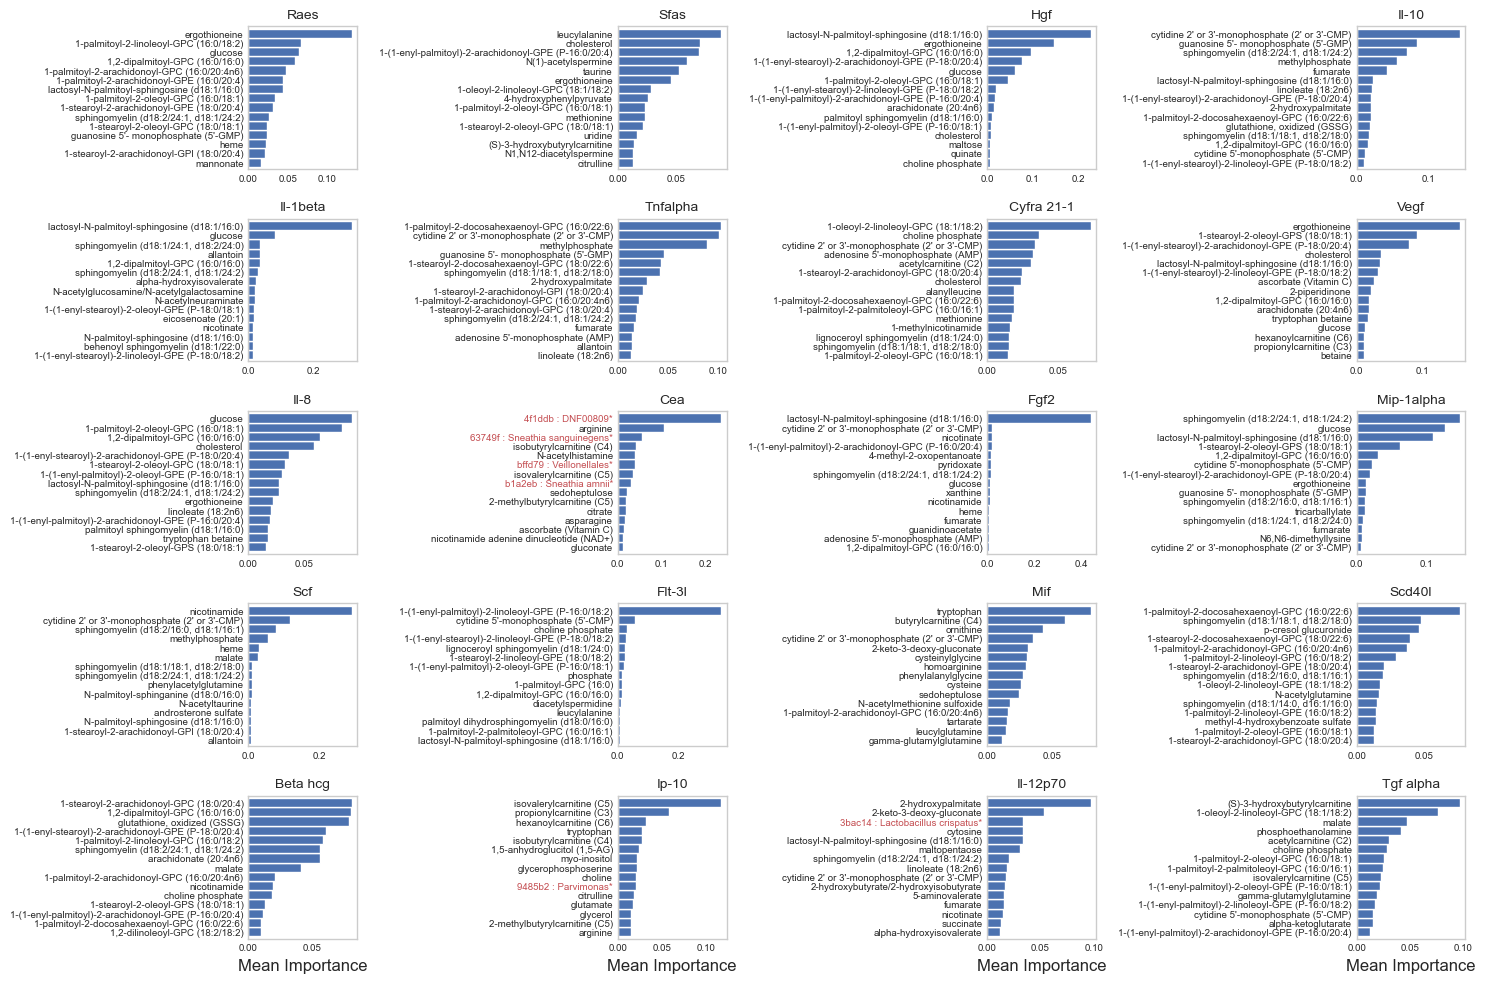

In [26]:
# print()
train_n_eval_regressors(ls_cancer_biomarkers,
                        'biomarkers_no_cancer',
                        transform_target2log=True,
                        ls_features=ls_features_biomarkers,
                        df_data=df_data_wo_cancer,
                        taxa=taxa,
                        seed=seed,
                        output_dir=output_dir)


### Predict actual value of Vaginal pH (`F_pcov_pH`)


Training regressors for 1 number of num_pH...
Estimator Accuracy: 0.0206724156754909 ± 0.009222259000210837
Scatterplots saved in: a-modelling-output/regressors/num_pH-rf-predictions-scatterplots.pdf


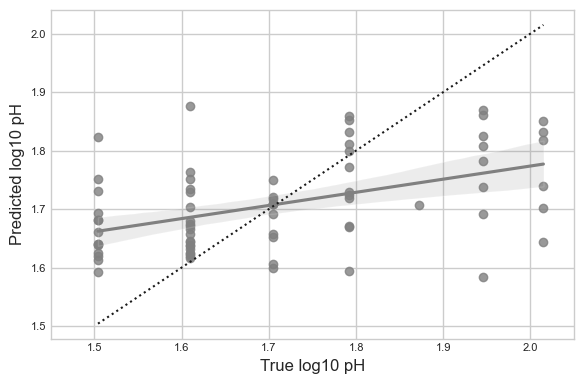

In [27]:
ls_features4ph = [x for x in df_data_w_targets_sel.columns if (
    x.startswith('F_') and not x.startswith('F_pcov_'))]
ls_target_num_pH = ['F_pcov_pH']

train_n_eval_regressors(ls_target_num_pH,
                        'num_pH',
                        True,
                        ls_features4ph,
                        df_data_w_targets_sel,
                        taxa,
                        seed,
                        output_dir)


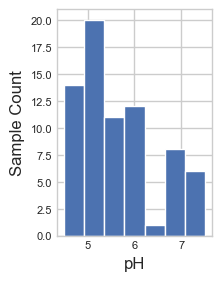

In [28]:
# Publication: Supplementary figure 10: numeric vaginal pH distribution
fig, ax = plt.subplots(1, figsize=(2, 3))
g = df_data_w_targets_sel['F_pcov_pH'].hist(ax=ax, bins=7)
ax.set_xlabel('pH')
ax.set_ylabel('Sample Count')
#ax.set_xticklabels([4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5])
fig.savefig(os.path.join(output_dir, 'regressors',
            'num_pH_histogram.jpeg'), bbox_inches='tight')


### Predict numeric inflammation score (`T_infl_score_flt`)


Training regressors for 1 number of num_inflammation...
Estimator Accuracy: 1.1688482142857142 ± 0.6284379587598159
Scatterplots saved in: a-modelling-output/regressors/num_inflammation-rf-predictions-scatterplots.pdf


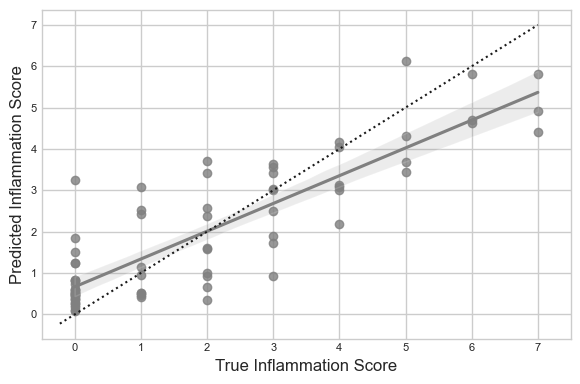

In [29]:
ls_target_num_inf = ['T_infl_score_flt']
train_n_eval_regressors(ls_target_num_inf,
                        'num_inflammation', False,
                        ls_features4inflammation,
                        df_data_w_targets_sel,
                        taxa,
                        seed,
                        output_dir)


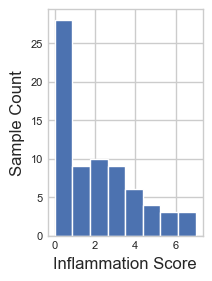

In [30]:
# Publication: Supplementary Figure 12: Inflammation score distribution

fig, ax = plt.subplots(1, figsize=(2, 3))
g = df_data_w_targets_sel['T_infl_score_flt'].hist(ax=ax, bins=8)
ax.set_xlabel('Inflammation Score')
ax.set_ylabel('Sample Count')
fig.savefig(os.path.join(output_dir, 'regressors',
            'num_inflammation_histogram.jpeg'), bbox_inches='tight')
plt.show()
